In [1]:
import sys
from pyrosetta import *
from pyrosetta.teaching import *
from pyrosetta.toolbox import cleanATOM
init()

PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python37.linux 2020.25+release.d2d9f90b8cbcacfd7a1f69aefa5de610b100e8a9 2020-06-19T14:33:13] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python37.linux r258 2020.25+release.d2d9f90 d2d9f90b8cbcacfd7a1f69aefa5de610b100e8a9 http://www.pyrosetta.org 2020-06-19T14:33:13
core.init: command: PyRosetta -ex1 -ex2aro -database /home/ning/anaconda3/lib/python3.7/site-packages/pyrosetta-2020.25+release.d2d9f90-py3.7-linux-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=598518504 seed_offset=0 real_seed=598518504
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=598518504 RG_type=mt19937


In [2]:
pose = pose_from_file('inputs/1V74.clean.pdb')
starting_pose = pose.clone()
cen_pose = pose.clone()
cen_switch = SwitchResidueTypeSetMover('centroid')
cen_switch.apply(cen_pose)
starting_cen_pose = cen_pose.clone()

core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 981 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 1.1591 seconds.
core.import_pose.import_pose: File 'inputs/1V74.clean.pdb' automatically determined to be of type PDB
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OXT on residue LEU:CtermProteinFull 107
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OXT on residue LEU:CtermProteinFull 194
core.chemical.GlobalResidueTypeSet: Finished initializing centroid residue type set.  Created 69 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 0.030227 seconds.


In [3]:
pose.sequence()

'LNDPLDSGRFSRKQLDKKYKHAGDFGISDTKKNRETLTKFRDAIEEHLSDKDTVEKGTYRREKGSKVYFNPNTMNVVIIKSNGEFLSGWKINPDADNGRIYLETGELMNKMAMIDLAKLFLASKITAIEFSERICVERRRLYGVKDLSPNILNCGEELFMAAERFEPDADRANYEIDDNGLKVEVRSILEKFKL'

In [4]:
cen_pose.sequence()

'LNDPLDSGRFSRKQLDKKYKHAGDFGISDTKKNRETLTKFRDAIEEHLSDKDTVEKGTYRREKGSKVYFNPNTMNVVIIKSNGEFLSGWKINPDADNGRIYLETGELMNKMAMIDLAKLFLASKITAIEFSERICVERRRLYGVKDLSPNILNCGEELFMAAERFEPDADRANYEIDDNGLKVEVRSILEKFKL'

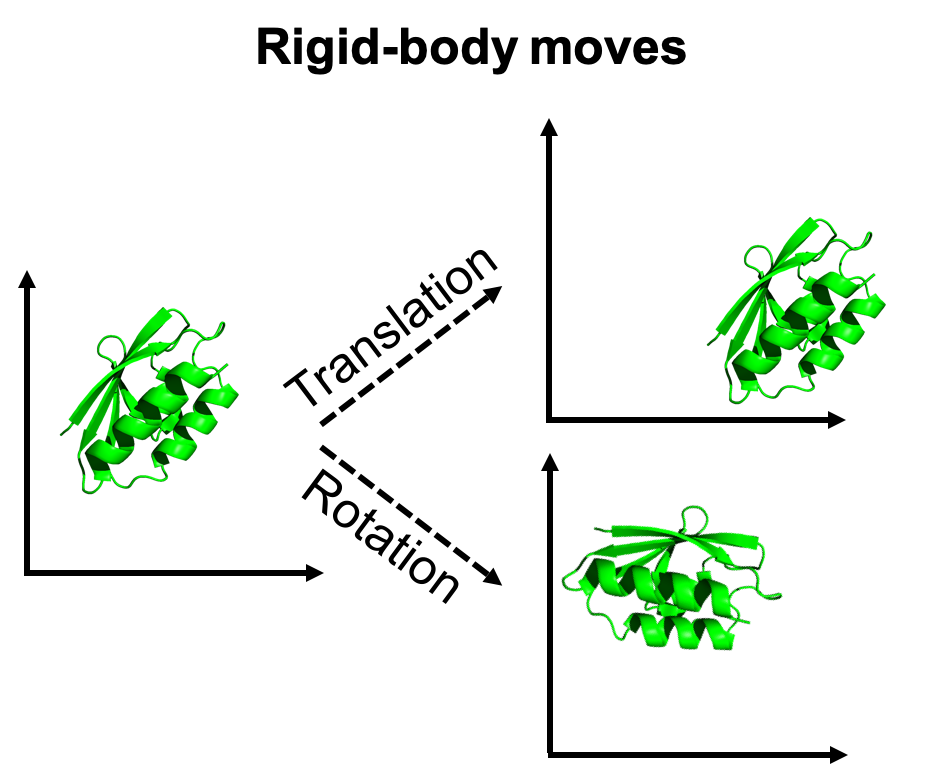

In [5]:
from IPython.core import display
display.Image('./Media/rigid-body.png', width = '400')

* Any rigid body moves needs to know which part moves and which part is fixed.
* In Rosetta, this division is known as a Jump and the set of protein segments and jumps are stored in an object attached to a pose called a FoldTree.
* In the FoldTree printout, each three number sequence following the word EDGE is the beginning and ending residue number, then a code. The codes are -1 for stretches of protein and any positive integer for a Jump, which represents the Jump number.

In [6]:
print(pose.fold_tree())

FOLD_TREE  EDGE 1 107 -1  EDGE 1 108 1  EDGE 108 194 -1 


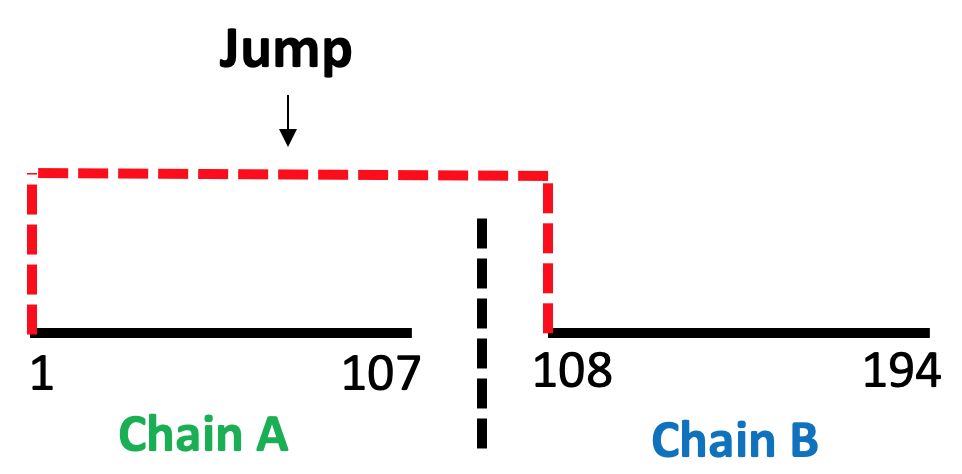

In [7]:
display.Image('./Media/first-jump.png', width = '400')

* By default, there is a Jump between the N-terminus of chain A and the N-terminus of chain B, which can be changed using the exposed method setup_foldtree().

In [8]:
from pyrosetta.rosetta.protocols.docking import setup_foldtree
print(pose.fold_tree())
setup_foldtree(pose, 'A_B', Vector1([1]))
setup_foldtree(starting_pose, 'A_B', Vector1([1]))
print(pose.fold_tree())

FOLD_TREE  EDGE 1 107 -1  EDGE 1 108 1  EDGE 108 194 -1 
FOLD_TREE  EDGE 1 88 -1  EDGE 88 107 -1  EDGE 88 158 1  EDGE 158 108 -1  EDGE 158 194 -1 


* the argument 'A_B' tells Rosetta to make chain A the 'rigid' chain and allow chain B to move. 'AB_C' means chain A and B rigid together as a single unit and allow chain C to move.
* The thirf argument Vector([1]) is required, it creates a Rosetta vector object - indexed from 1 - with one element that identifies the first Jump in the FoldTree for docking use.

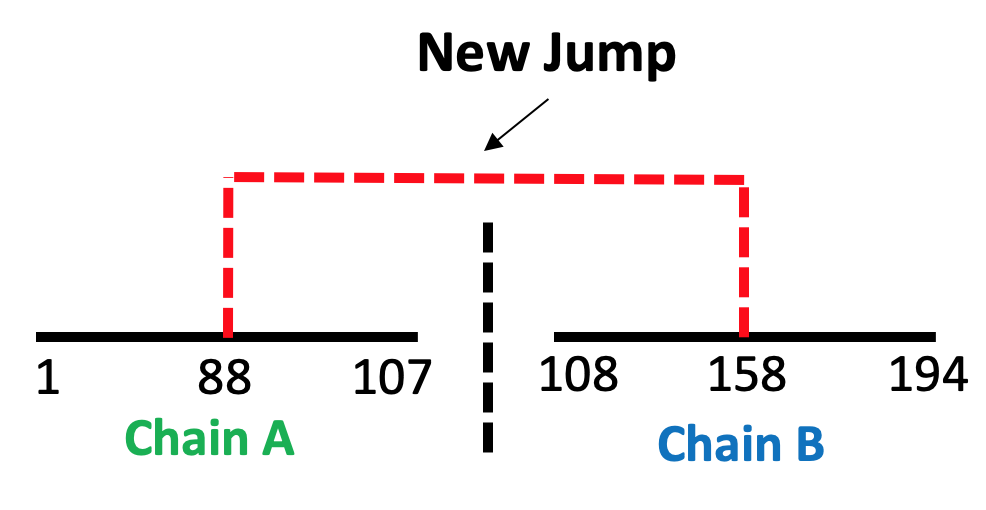

In [9]:
display.Image('./Media/second-jump.png', width = '400')

In [10]:
jump_num = 1
print(pose.jump(jump_num).get_rotation())
print(pose.jump(jump_num).get_translation())

    -0.7685217364647530     -0.5410492486350574     -0.3415260621572546
    -0.4152200273442834      0.8278586413578786     -0.3771503663279441
     0.4867922241299825     -0.1480397935709464     -0.8608818444165591

     -2.528204534753765      -11.32734702901772      -11.01155062262598


# RigidBody Movers

In [11]:
import pyrosetta.rosetta.protocols.rigid as rigid_moves
pert_mover = rigid_moves.RigidBodyPerturbMover(jump_num, 8, 3) # a mean of 8 degree rotation
# and 3 A translation

In [12]:
pymol = PyMOLMover()
pymol.keep_history(True)
pose.pdb_info().name('pose')
pymol.apply(pose)

In [13]:
pert_mover.apply(pose)
pymol.apply(pose)

In [14]:
print(pose.jump(jump_num).get_rotation())
print(pose.jump(jump_num).get_translation())

    -0.7979399680008660     -0.5322514094926947     -0.2828431447990523
    -0.3901878163287218      0.8138135072266915     -0.4306518819696693
     0.4593966428429821     -0.2332723998856977     -0.8570523391229758

     -3.141972710811726      -7.068713076593489      -11.87860528091453


In [15]:
randomize1 = rigid_moves.RigidBodyRandomizeMover(pose, jump_num, 
                                                 rigid_moves.partner_upstream)
randomize2 = rigid_moves.RigidBodyRandomizeMover(pose, jump_num,
                                                rigid_moves.partner_downstream)

In [16]:
randomize1.apply(pose)
randomize2.apply(pose)

protocols.moves.RigidBodyMover: Randomize: Jump (before): RT -0.79794 -0.532251 -0.282843 -0.390188 0.813814 -0.430652 0.459397 -0.233272 -0.857052 -3.14197 -7.06871 -11.8786
protocols.moves.RigidBodyMover: Randomize: Rot. Center (before): 8.41166 24.8844 13.8747
protocols.geometry.RB_geometry: random_reorientation_matrix phi: 328.433 psi: 40.3141 theta: 69.6761
protocols.moves.RigidBodyMover: Randomize: Jump (after):  RT -0.842557 0.418457 0.339105 0.336616 0.9006 -0.27497 -0.420461 -0.11753 -0.899666 4.76993 -5.25226 -12.2245
protocols.moves.RigidBodyMover: Randomize: Rot. Center (after):  8.41166 24.8844 13.8747
protocols.moves.RigidBodyMover: Randomize: ---
protocols.moves.RigidBodyMover: Randomize: Jump (before): RT -0.842557 0.418457 0.339105 0.336616 0.9006 -0.27497 -0.420461 -0.11753 -0.899666 4.76993 -5.25226 -12.2245
protocols.moves.RigidBodyMover: Randomize: Rot. Center (before): 4.43449 40.0741 18.9422
protocols.geometry.RB_geometry: random_reorientation_matrix phi: 23.5019

In [17]:
pymol.apply(pose)

* the FaDockingSlideIntoContact Mover will translate the downstream protein along the line of protein centers until the proteins are in contact.

In [18]:
slide = DockingSlideIntoContact(jump_num) # For centroid mode
slide = FaDockingSlideIntoContact(jump_num) # For full-atom mode
slide.apply(pose)

basic.io.database: Database file opened: scoring/score_functions/EnvPairPotential/env_log.txt
basic.io.database: Database file opened: scoring/score_functions/EnvPairPotential/cbeta_den.txt
basic.io.database: Database file opened: scoring/score_functions/EnvPairPotential/pair_log.txt
basic.io.database: Database file opened: scoring/score_functions/EnvPairPotential/cenpack_log.txt
basic.io.database: Database file opened: scoring/score_functions/InterchainPotential/interchain_env_log.txt
basic.io.database: Database file opened: scoring/score_functions/InterchainPotential/interchain_pair_log.txt
core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
protocols.moves.RigidBodyMover: Translate:

In [19]:
pymol.apply(pose)

In [20]:
movemap = MoveMap()
movemap.set_jump(jump_num, True)
min_mover = MinMover()
min_mover.movemap(movemap)
scorefxn = get_fa_scorefxn()
min_mover.score_function(scorefxn)

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/AccStrength.csv
basic.io.database: Database file opened: scoring/score_functions/rama/fd/all.ramaProb
basic.io.database: Database file opened: scoring/score_functions/rama/fd/prepro.ramaProb
basic.io.database: Database file opened: scoring/score_functions/omega/omega_ppdep.all.txt
basic.io.database: Database file opened: scoring/score_functions/omega/omega_ppdep.gly.txt
basic.io.database: Database file opened: scoring/score_functions/omega/ome

In [21]:
scorefxn(pose)
min_mover.apply(pose)
print(pose.jump(jump_num).get_rotation())
print(pose.jump(jump_num).get_translation())

basic.io.database: Database file opened: scoring/score_functions/elec_cp_reps.dat
core.scoring.elec.util: Read 40 countpair representative atoms
core.pack.dunbrack.RotamerLibrary: shapovalov_lib_fixes_enable option is true.
core.pack.dunbrack.RotamerLibrary: shapovalov_lib::shap_dun10_smooth_level of 1( aka lowest_smooth ) got activated.
core.pack.dunbrack.RotamerLibrary: Binary rotamer library selected: /home/ning/anaconda3/lib/python3.7/site-packages/pyrosetta-2020.25+release.d2d9f90-py3.7-linux-x86_64.egg/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin
core.pack.dunbrack.RotamerLibrary: Using Dunbrack library binary file '/home/ning/anaconda3/lib/python3.7/site-packages/pyrosetta-2020.25+release.d2d9f90-py3.7-linux-x86_64.egg/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin'.
core.pack.dunbrack.RotamerLibrary: Dunbrack 2010 library took 0.16039 seconds to load from binary
    -0.4176013550893254     -0.5061999043279398     -0.75456660745486

In [22]:
scorefxn.score(pose)

-210.25562591897247

# Low-Resolution Docking via RosettaDock

In [23]:
scorefxn_low = create_score_function('interchain_cen')

In [24]:
dock_lowres = DockingLowRes(scorefxn_low, jump_num)
print(cen_pose.fold_tree())
setup_foldtree(cen_pose, 'A_B', Vector1([1]))
print(cen_pose.fold_tree())
dock_lowres.apply(cen_pose)

FOLD_TREE  EDGE 1 107 -1  EDGE 1 108 1  EDGE 108 194 -1 
FOLD_TREE  EDGE 1 88 -1  EDGE 88 107 -1  EDGE 88 158 1  EDGE 158 108 -1  EDGE 158 194 -1 
protocols.docking.DockingLowRes: in DockingLowRes.apply
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ///                       Docking Low Res Protocol                           ///
protocols.docking.DockingLowRes: ///                                                                          ///
protocols.docking.DockingLowRes: /// Centroid Inner Cycles: 50                                                ///
protocols.docking.DockingLowRes: /// Centroid Outer Cycles: 10                                                ///
protocols.docking.DockingLowRes: /// Scorefunction:                                                           ///
protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (intercha

protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_max_network_size_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_energy_threshold_: -0.25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_probe_radius_: 2.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_backbone_:1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_natural_corrections1_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_p

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.DockingLowRes: Rotation magnitude: 4.5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes:

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.5103
protocols.docking.DockingLowRes: Rotation magnitude: 3.645
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLow

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

In [25]:
print(CA_rmsd(cen_pose, starting_cen_pose))
print(calc_Lrmsd(cen_pose, starting_cen_pose, Vector1([1])))

1.6405293941497803
3.8600701445978167


In [26]:
cen_pose.pdb_info().name('cen_pose')
pymol.apply(cen_pose)
pymol.apply(pose)

# Job Distributor
* decoys - candidate structures.

In [27]:
jd = PyJobDistributor('output', 100, scorefxn_low)
# starting_cen_pose should be the native crystal structure
jd.native_pose = starting_cen_pose

Working on decoy: output_66.pdb


In [28]:
while not jd.job_complete:
    cen_pose.assign(starting_cen_pose)
    dock_lowres.apply(cen_pose)
    jd.output_decoy(cen_pose)

protocols.docking.DockingLowRes: in DockingLowRes.apply
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ///                       Docking Low Res Protocol                           ///
protocols.docking.DockingLowRes: ///                                                                          ///
protocols.docking.DockingLowRes: /// Centroid Inner Cycles: 50                                                ///
protocols.docking.DockingLowRes: /// Centroid Outer Cycles: 10                                                ///
protocols.docking.DockingLowRes: /// Scorefunction:                                                           ///
protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files:
protocols.docking.DockingLowRes: Ene

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_probe_radius_: 2.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_backbone_:1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_natural_corrections1_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb_:0
protocols.docking.DockingLowRes: EnergyMethodOptions:

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.12
protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.DockingLowRes: Rotation magnitude: 4.5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes:

protocols.docking.DockingLowRes: Rotation magnitude: 3.645
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_wat_penalty: 1.221
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_pt_wat_penalty: 2.709
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_ref_seq_length_: 9
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_term_length_: 3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_pssm_feat_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_avg_rank_as_energy_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOpti

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D0: 6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_S: 0.4
protocols.docking.DockingLowRes: EnergyMethodOptions::show: smooth_fa_elec: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_type: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param2: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_hbond: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockingLowRes: EnergyMethodOptions::sho

protocols.docking.DockingLowRes: HBondOptions::show: measure_sp3acc_BAH_from_hvy_: true
protocols.docking.DockingLowRes: HBondOptions::show: fade_energy_: 1
protocols.docking.DockingLowRes: HBondOptions::show: exclude_ether_oxygens_: 0
protocols.docking.DockingLowRes: HBondOptions::show: Mbhbond: false
protocols.docking.DockingLowRes: HbondOptions::show: mphbond: false
protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show: water_hybrid_sf: false
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: syn_G_potential_bonus: 0
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: torsion_potential: ps_04282011
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_suite_bonus: -1


protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowR

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLo

protocols.docking.DockingLowRes: Translation magnitude: 0.301327
protocols.docking.DockingLowRes: Rotation magnitude: 2.15234
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.dockin

protocols.docking.DockingLowRes: /// Centroid Inner Cycles: 50                                                ///
protocols.docking.DockingLowRes: /// Centroid Outer Cycles: 10                                                ///
protocols.docking.DockingLowRes: /// Scorefunction:                                                           ///
protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: mhc_epitope_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: netcharge_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: aspartimide_penalty_value: 25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
E

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_backbone_:1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_natural_corrections1_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: target_clash_pdb_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_prefix_: traj
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_gz_: FALSE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_stride_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_

protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.DockingLowRes: Rotation magnitude: 4.5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_avg_rank_as_energy_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_defi

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.271194
protocols.docking.DockingLowRes: Rotation magnitude: 1.9371
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Docking

protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param2: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_hbond: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_gen_kirkwood: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: protein_dielectric: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: water_dielectric: 78.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: EnergyMethodOptions::sh

protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show: water_hybrid_sf: false
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: syn_G_potential_bonus: 0
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: torsion_potential: ps_04282011
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_suite_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_2HOprime_bonus: -0.5
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_sugar_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: pack_phosphate_penalty: 0.25
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_side_chain_bonus: -0.5
protocols.docking.DockingLowRes: 
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.567
protocols.docking.DockingLowRes: Rotation magnitude: 4.05
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRe

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingL

protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: mhc_epitope_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: netcharge_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: aspartimide_penalty_value: 25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
protocols.docking.DockingLowRes: EnergyMethodOptions::show: at

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_natural_corrections1_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: target_clash_pdb_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_prefix_: traj
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_gz_: FALSE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_stride_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_central_atoms_to_score:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_residue_type_param_set: none
protocols.docking.DockingLowRes: HBondOptions::show: hb_max_energy: 0
protocols.docking.DockingLowRes

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_avg_rank_as_energy_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_:
protoc

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.04
protocols.docking.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.271194
protocols.docking.DockingLowRes: Rotation magnitude: 1.9371
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Docking

protocols.docking.DockingLowRes: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_gen_kirkwood: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: protein_dielectric: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: water_dielectric: 78.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_intra_res_protein: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_hybrid: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_full: false
protocols.docking.DockingLowRes: EnergyMetho

protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: torsion_potential: ps_04282011
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_suite_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_2HOprime_bonus: -0.5
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_sugar_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: pack_phosphate_penalty: 0.25
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_side_chain_bonus: -0.5
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ::::::::::::::::::Centroid Adaptive:::::::::::::::::::
protocols.dock

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.12
protocols.docking.DockingLowRes: Translation magnitude: 0.567
protocols.docking.DockingLowRes: Rotation magnitude: 4.05
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRe

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowR

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: mhc_epitope_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: netcharge_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: aspartimide_penalty_value: 25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
protocols.docking.DockingLowRes: EnergyMethodOptions::show: atom_vdw_atom_type_set_name: centroid
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_fa_input:
protocols.docki

protocols.docking.DockingLowRes: EnergyMethodOptions::show: target_clash_pdb_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_prefix_: traj
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_gz_: FALSE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_stride_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_central_atoms_to_score:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_residue_type_param_set: none
protocols.docking.DockingLowRes: HBondOptions::show: hb_max_energy: 0
protocols.docking.DockingLowRes: HBondOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_protein_: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_RNA_: false
protocols.docking.DockingLowRes: HBondOptions::show: put_intra_into_total_: false
protocols.docking.DockingLowRes: HBondOptions::show: exclude_self_

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_containing_cones_cutoff_:6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_distance_cutoff_: 8
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_dotproduct_cutoff_: 0.1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_grid_padding_: 1
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.Doc

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.334808
protocols.docking.DockingLowRes: Rotation magnitude: 2.39148
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLo

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.12
protocols.docking.DockingLowRes: Translation magnitude: 0.271194
protocols.docking.DockingLowRes: Rotation magnitude: 1.9371
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Docking

protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_gen_kirkwood: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: protein_dielectric: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: water_dielectric: 78.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_intra_res_protein: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_hybrid: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_full: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: put_intra_into_total: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_interres_path_distance_cutoff: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_intrares_path_distance_cutoff: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: eval_intrares_elec_ST_only: false
protocols.docking

protocols.docking.DockingLowRes: FreeDOF_Options::show: free_2HOprime_bonus: -0.5
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_sugar_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: pack_phosphate_penalty: 0.25
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_side_chain_bonus: -0.5
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ::::::::::::::::::Centroid Adaptive:::::::::::::::::::
protocols.docking.DockingLowRes: Translation magnitude: 0.7
protocols.docking.DockingLowRes: Rotation magnitude: 5
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Docki

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.567
protocols.docking.DockingLowRes: Rotation magnitude: 4.05
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRe

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
protocols.docking.DockingLowRes: EnergyMethodOptions::show: atom_vdw_atom_type_set_name: centroid
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_fa_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_RNA_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_protein_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_monomer_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_max_dis: 5.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: el

protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_residue_type_param_set: none
protocols.docking.DockingLowRes: HBondOptions::show: hb_max_energy: 0
protocols.docking.DockingLowRes: HBondOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_protein_: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_RNA_: false
protocols.docking.DockingLowRes: HBondOptions::show: put_intra_into_total_: false
protocols.docking.DockingLowRes: HBondOptions::show: exclude_self_hbonds: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: smooth_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: bb_donor_acceptor_check: true
protocols.docking.DockingLowRes: HBondOptions::show: decompose_bb_hb_into_pair_energies: false
protocols.docking.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.14
Working on decoy: output_4.pdb
protocols.docking.DockingLowRes: in DockingLowRes.apply
protocols.docking.DockingLowRes: //////////////////////////////

protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_containing_cones_cutoff_:6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_distance_cutoff_: 8
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_dotproduct_cutoff_: 0.1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_grid_padding_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_size_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_disabled_except_during_packing_: TRUE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_bonus_ramping_function_: "quadratic"
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_max_network_size_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_energy_threshold_: -0.25
protocols.docking.DockingLowRes: EnergyMe

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.5103
protocols.docking.DockingLowRes: Rotation magnitude: 3.645
protocols.docking.DockingLow

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.413343
protocols.docking.DockingLowRes: Rotation magnitude: 2.95245
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.334808
protocols.docking.DockingLowRes: Rotation magnitude: 2.39148
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: put_intra_into_total: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_interres_path_distance_cutoff: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_intrares_path_distance_cutoff: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: eval_intrares_elec_ST_only: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: envsmooth_zero_negatives: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: cst_max_seq_sep: 18446744073709551615
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_bound_tag: bound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_unbound_tag: unbound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: arg_cation_pi_his_can_be_pi: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_wat_penalty: 1.221
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_pt_wat_

protocols.docking.DockingLowRes: Translation magnitude: 0.7
protocols.docking.DockingLowRes: Rotation magnitude: 5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLo

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_RNA_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_protein_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_monomer_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_max_dis: 5.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_min_dis: 1.6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_die: 10
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_no_dis_dep_die: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_die: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D: 80
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D0: 6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_S: 0.4
protocols.docking.DockingLowRes: EnergyMethodOptions::show: smooth_fa_elec: tr

protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: smooth_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: bb_donor_acceptor_check: true
protocols.docking.DockingLowRes: HBondOptions::show: decompose_bb_hb_into_pair_energies: false
protocols.docking.DockingLowRes: HBondOptions::show: params_database_tag_: ref2015_params
protocols.docking.DockingLowRes: HBondOptions::show: use_sp2_chi_penalty_: true
protocols.docking.DockingLowRes: HBondOptions::show: sp2_BAH180_rise_: 0.75
protocols.docking.DockingLowRes: HBondOptions::show: sp2_outer_width_: 0.357
protocols.docking.DockingLowRes: HBondOptions::show: measure_sp3acc_BAH_from_hvy_: true
protocols.docking.DockingLowRes: HBondOptions::show: fade_energy_: 1
protocols.docking.DockingLowRes: HBondOptions::show: exclude_ether_oxygens_: 0
protocols.docking.DockingLowRes: H

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.301327
protocols.docking.DockingLowRes: Rotation magnitude: 2.15234
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
Working on decoy: output_31.pdb
protocols.docking.DockingLowRes: in DockingLowRes.apply
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ///                       Docking Low Res Protocol                           ///
protocols.docking.DockingLowRes: ///                                                                          ///
protocols.docking.DockingLowRes: /// Centroid Inner Cycles: 50                                                ///
protocols.docking.DockingLowRes: /// Centroid Outer Cycles: 10                                                ///
protocols.docking.Do

protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_disabled_except_during_packing_: TRUE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_bonus_ramping_function_: "quadratic"
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_max_network_size_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_energy_threshold_: -0.25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_probe_radius_: 2.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.1
protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.DockingLowRes: Rotation magnitude: 4.5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: 

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.5103
protocols.docking.DockingLowRes: Rotation magnitude: 3.645
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLow

protocols.docking.DockingLowRes: Rotation magnitude: 2.95245
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docki

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: cst_max_seq_sep: 18446744073709551615
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_bound_tag: bound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_unbound_tag: unbound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: arg_cation_pi_his_can_be_pi: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_wat_penalty: 1.221
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_pt_wat_penalty: 2.709
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_ref_seq_length_: 9
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_term_length_: 3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_pssm_feat_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_: 0
protocols.docking.DockingLowRes: EnergyMethodO

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_die: 10
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_no_dis_dep_die: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_die: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D: 80
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D0: 6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_S: 0.4
protocols.docking.DockingLowRes: EnergyMethodOptions::show: smooth_fa_elec: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_type: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param2: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_hbond: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.Dockin

protocols.docking.DockingLowRes: HBondOptions::show: params_database_tag_: ref2015_params
protocols.docking.DockingLowRes: HBondOptions::show: use_sp2_chi_penalty_: true
protocols.docking.DockingLowRes: HBondOptions::show: sp2_BAH180_rise_: 0.75
protocols.docking.DockingLowRes: HBondOptions::show: sp2_outer_width_: 0.357
protocols.docking.DockingLowRes: HBondOptions::show: measure_sp3acc_BAH_from_hvy_: true
protocols.docking.DockingLowRes: HBondOptions::show: fade_energy_: 1
protocols.docking.DockingLowRes: HBondOptions::show: exclude_ether_oxygens_: 0
protocols.docking.DockingLowRes: HBondOptions::show: Mbhbond: false
protocols.docking.DockingLowRes: HbondOptions::show: mphbond: false
protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show: water_hybrid_sf: false
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: syn_G_potential_bonus: 0
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: t

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.04
protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.301327
protocols.docking.DockingLowRes: Rotation magnitude: 2.15234
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ///                       Docking Low Res Protocol                           ///
protocols.docking.DockingLowRes: ///                                                                          ///
protocols.docking.DockingLowRes: /// Centroid Inner Cycles: 50                                                ///
protocols.docking.DockingLowRes: /// Centroid Outer Cycles: 10                                                ///
protocols.docking.DockingLowRes: /// Scorefunction:                                                           ///
protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: mhc_epitope_setup_files:
protoco

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_probe_radius_: 2.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_backbone_:1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_natural_corrections1_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb_:0
protocols.docking.DockingLowRes: EnergyMethodOptions:

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.1
protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.DockingLowRes: Rotation magnitude: 4.5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: 

protocols.docking.DockingLowRes: Translation magnitude: 0.5103
protocols.docking.DockingLowRes: Rotation magnitude: 3.645
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Do

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_wat_penalty: 1.221
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_pt_wat_penalty: 2.709
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_ref_seq_length_: 9
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_term_length_: 3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_pssm_feat_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_avg_rank_as_energy_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOpti

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D0: 6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_S: 0.4
protocols.docking.DockingLowRes: EnergyMethodOptions::show: smooth_fa_elec: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_type: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param2: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_hbond: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockingLowRes: EnergyMethodOptions::sho

protocols.docking.DockingLowRes: HBondOptions::show: measure_sp3acc_BAH_from_hvy_: true
protocols.docking.DockingLowRes: HBondOptions::show: fade_energy_: 1
protocols.docking.DockingLowRes: HBondOptions::show: exclude_ether_oxygens_: 0
protocols.docking.DockingLowRes: HBondOptions::show: Mbhbond: false
protocols.docking.DockingLowRes: HbondOptions::show: mphbond: false
protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show: water_hybrid_sf: false
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: syn_G_potential_bonus: 0
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: torsion_potential: ps_04282011
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_suite_bonus: -1


protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingL

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.1
protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Docking

protocols.docking.DockingLowRes: Translation magnitude: 0.301327
protocols.docking.DockingLowRes: Rotation magnitude: 2.15234
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.dockin

protocols.docking.DockingLowRes: /// Centroid Inner Cycles: 50                                                ///
protocols.docking.DockingLowRes: /// Centroid Outer Cycles: 10                                                ///
protocols.docking.DockingLowRes: /// Scorefunction:                                                           ///
protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: mhc_epitope_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: netcharge_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: aspartimide_penalty_value: 25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
E

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_backbone_:1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_natural_corrections1_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: target_clash_pdb_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_prefix_: traj
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_gz_: FALSE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_stride_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_

protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.DockingLowRes: Rotation magnitude: 4.5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_avg_rank_as_energy_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_defi

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.271194
protocols.docking.DockingLowRes: Rotation magnitude: 1.9371
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Docking

protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param2: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_hbond: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_gen_kirkwood: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: protein_dielectric: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: water_dielectric: 78.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_intra_res_protein: true
protocols.docking.DockingLowRes: EnergyMethodOp

protocols.docking.DockingLowRes: HBondOptions::show: water_hybrid_sf: false
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: syn_G_potential_bonus: 0
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: torsion_potential: ps_04282011
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_suite_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_2HOprime_bonus: -0.5
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_sugar_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: pack_phosphate_penalty: 0.25
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_side_chain_bonus: -0.5
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: //////////////////

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.567
protocols.docking.DockingLowRes: Rotation magnitude: 4.05
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRe

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingL

protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: mhc_epitope_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: netcharge_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: aspartimide_penalty_value: 25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
protocols.docking.DockingLowRes: EnergyMethodOptions::show: at

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: target_clash_pdb_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_prefix_: traj
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_gz_: FALSE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_stride_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_central_atoms_to_score:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_residue_type_param_set: none
protocols.docking.DockingLowRes: HBondOptions::show: hb_max_energy: 0
protocols.docking.DockingLowRes: HBondOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_pr

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_containing_cones_cutoff_:6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_distance_cutoff_: 8
protocols.docking.DockingLowRes: EnergyMethodOptions::sho

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.334808
protocols.docking.DockingLowRes: Rotation magnitude: 2.39148
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Acceptance rate is: 0.14
protocols.docking.DockingLowRes: Translation magnitude: 0.271194
protocols.docking.DockingLowRes: Rotation magnitude: 1.9371
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Docking

protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_gen_kirkwood: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: protein_dielectric: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: water_dielectric: 78.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_intra_res_protein: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_hybrid: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_full: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: put_intra_into_total: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_interres_path_distance_cutoff: false
protocols.docking.DockingLowRes: EnergyMetho

protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_suite_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_2HOprime_bonus: -0.5
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_sugar_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: pack_phosphate_penalty: 0.25
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_side_chain_bonus: -0.5
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ::::::::::::::::::Centroid Adaptive:::::::::::::::::::
protocols.docking.DockingLowRes: Translation magnitude: 0.7
protocols.docking.DockingLowRes: Rotation magnitude: 5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Do

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.567
protocols.docking.DockingLowRes: Rotation magnitude: 4.05
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRe

protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
protocols.docking.DockingLowRes: EnergyMethodOptions::show: atom_vdw_atom_type_set_name: centroid
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_fa_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_RNA_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_protein_fa_

protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_stride_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_central_atoms_to_score:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_residue_type_param_set: none
protocols.docking.DockingLowRes: HBondOptions::show: hb_max_energy: 0
protocols.docking.DockingLowRes: HBondOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_protein_: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_RNA_: false
protocols.docking.DockingLowRes: HBondOptions::show: put_intra_into_total_: false
protocols.docking.DockingLowRes: HBondOptions::show: exclude_self_hbonds: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: smooth_hb_env_dep: true
protocols.dock

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_containing_cones_cutoff_:6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_distance_cutoff_: 8
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_dotproduct_cutoff_: 0.1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_grid_padding_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_size_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_disabled_except_during_packing_: TRUE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_bonus_ramping_function_: "quadratic"
protocols

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Acceptance rate is: 0.16
protocols.docking.DockingLowRes: Translation magnitude: 0.413343
protocols.docking.DockingLowRes: Rotation magnitude: 2.95245
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.04
protocols.docking.DockingLowRes: Translation magnitude: 0.334808
protocols.docking.DockingLowRes: Rotation magnitude: 2.39148
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_intra_res_protein: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_hybrid: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_full: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: put_intra_into_total: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_interres_path_distance_cutoff: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_intrares_path_distance_cutoff: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: eval_intrares_elec_ST_only: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: envsmooth_zero_negatives: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: cst_max_seq_sep: 18446744073709551615
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_bound_tag: bound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_unbound_tag: u

protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ::::::::::::::::::Centroid Adaptive:::::::::::::::::::
protocols.docking.DockingLowRes: Translation magnitude: 0.7
protocols.docking.DockingLowRes: Rotation magnitude: 5
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Doc

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_fa_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_RNA_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_protein_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_monomer_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_max_dis: 5.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_min_dis: 1.6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_die: 10
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_no_dis_dep_die: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_die: true
protocols.docking.DockingLowRes: EnergyMethodOptio

protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_RNA_: false
protocols.docking.DockingLowRes: HBondOptions::show: put_intra_into_total_: false
protocols.docking.DockingLowRes: HBondOptions::show: exclude_self_hbonds: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: smooth_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: bb_donor_acceptor_check: true
protocols.docking.DockingLowRes: HBondOptions::show: decompose_bb_hb_into_pair_energies: false
protocols.docking.DockingLowRes: HBondOptions::show: params_database_tag_: ref2015_params
protocols.docking.DockingLowRes: HBondOptions::show: use_sp2_chi_penalty_: true
protocols.docking.DockingLowRes: HBondOptions::show: sp2_BAH180_rise_: 0.75
protocols.docking.DockingLowRes: HBondOptions::show: sp2_outer_width_: 0.357
protocols.docking.DockingL

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.12
protocols.docking.DockingLowRes: Translation magnitude: 0.301327
protocols.docking.D

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
Working on decoy: output_1.pdb
protocols.docking.DockingLowRes: in DockingLowRes.apply
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ///                       Docking Low Res Protocol                           ///
protocols.docking.DockingLowRes: ///                                                                          ///
protocols.docking.DockingLowRes: /// Centroid Inner

protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_grid_padding_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_size_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_disabled_except_during_packing_: TRUE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_bonus_ramping_function_: "quadratic"
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_max_network_size_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_energy_threshold_: -0.25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_probe_radius_: 2.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.12
protocols.docking.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.5103
protocols.docking.DockingLowRes: Rotation magnitude: 3.645
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLow

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.413343
protocols.docking.DockingLowRes: Rotation magnitude: 2.95245
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: eval_intrares_elec_ST_only: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: envsmooth_zero_negatives: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: cst_max_seq_sep: 18446744073709551615
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_bound_tag: bound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_unbound_tag: unbound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: arg_cation_pi_his_can_be_pi: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_wat_penalty: 1.221
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_pt_wat_penalty: 2.709
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_ref_seq_length_: 9
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_term_length_: 3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_pssm_feat_: 1
protocols.docking.DockingLowRes:

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_monomer_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_max_dis: 5.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_min_dis: 1.6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_die: 10
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_no_dis_dep_die: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_die: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D: 80
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D0: 6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_S: 0.4
protocols.docking.DockingLowRes: EnergyMethodOptions::show: smooth_fa_elec: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_type: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docki

protocols.docking.DockingLowRes: HBondOptions::show: bb_donor_acceptor_check: true
protocols.docking.DockingLowRes: HBondOptions::show: decompose_bb_hb_into_pair_energies: false
protocols.docking.DockingLowRes: HBondOptions::show: params_database_tag_: ref2015_params
protocols.docking.DockingLowRes: HBondOptions::show: use_sp2_chi_penalty_: true
protocols.docking.DockingLowRes: HBondOptions::show: sp2_BAH180_rise_: 0.75
protocols.docking.DockingLowRes: HBondOptions::show: sp2_outer_width_: 0.357
protocols.docking.DockingLowRes: HBondOptions::show: measure_sp3acc_BAH_from_hvy_: true
protocols.docking.DockingLowRes: HBondOptions::show: fade_energy_: 1
protocols.docking.DockingLowRes: HBondOptions::show: exclude_ether_oxygens_: 0
protocols.docking.DockingLowRes: HBondOptions::show: Mbhbond: false
protocols.docking.DockingLowRes: HbondOptions::show: mphbond: false
protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show:

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.301327
protocols.docking.DockingLowRes: Rotation magnitude: 2.15234
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLo

protocols.docking.DockingLowRes: Acceptance rate is: 0.04
Working on decoy: output_0.pdb
protocols.docking.DockingLowRes: in DockingLowRes.apply
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ///                       Docking Low Res Protocol                           ///
protocols.docking.DockingLowRes: ///                                                                          ///
protocols.docking.DockingLowRes: /// Centroid Inner Cycles: 50                                                ///
protocols.docking.DockingLowRes: /// Centroid Outer Cycles: 10                                                ///
protocols.docking.DockingLowRes: /// Scorefunction:                                                           ///
protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: En

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_energy_threshold_: -0.25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_probe_radius_: 2.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_backbone_:1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_natural_corrections1_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions:

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.1
protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.DockingLowRes: Rotation magnitude: 4.5
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: 

protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.5103
protocols.docking.DockingLowRes: Rotation magnitude: 3.645
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: arg_cation_pi_his_can_be_pi: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_wat_penalty: 1.221
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_pt_wat_penalty: 2.709
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_ref_seq_length_: 9
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_term_length_: 3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_pssm_feat_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_avg_rank_as_energy_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMetho

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D: 80
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D0: 6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_S: 0.4
protocols.docking.DockingLowRes: EnergyMethodOptions::show: smooth_fa_elec: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_type: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param2: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_hbond: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show:

protocols.docking.DockingLowRes: HBondOptions::show: sp2_outer_width_: 0.357
protocols.docking.DockingLowRes: HBondOptions::show: measure_sp3acc_BAH_from_hvy_: true
protocols.docking.DockingLowRes: HBondOptions::show: fade_energy_: 1
protocols.docking.DockingLowRes: HBondOptions::show: exclude_ether_oxygens_: 0
protocols.docking.DockingLowRes: HBondOptions::show: Mbhbond: false
protocols.docking.DockingLowRes: HbondOptions::show: mphbond: false
protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show: water_hybrid_sf: false
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: syn_G_potential_bonus: 0
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: torsion_potential: ps_04282011
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat


protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingL

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.301327
protocols.docking.DockingLowRes: Rotation magnitude: 2.15234
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: ///                                                                          ///
protocols.docking.DockingLowRes: /// Centroid Inner Cycles: 50                                                ///
protocols.docking.DockingLowRes: /// Centroid Outer Cycles: 10                                                ///
protocols.docking.DockingLowRes: /// Scorefunction:                                                           ///
protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: mhc_epitope_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: netcharge_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: aspartimide_penalty_value: 25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: et

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_backbone_:1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_natural_corrections1_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: target_clash_pdb_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_prefix_: traj
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_gz_: FALSE
protocols.docking.DockingLowRes: En

protocols.docking.DockingLowRes: Acceptance rate is: 0.1
protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.DockingLowRes: Rotation magnitude: 4.5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: 

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_pssm_feat_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_avg_rank_as_energy_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_li

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.271194
protocols.docking.DockingLowRes: Rotation magnitude: 1.9371
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLow

protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param2: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_hbond: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_gen_kirkwood: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: protein_dielectric: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: water_dielectric: 78.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: EnergyMethodOptions::sh

protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show: water_hybrid_sf: false
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: syn_G_potential_bonus: 0
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: torsion_potential: ps_04282011
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_suite_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_2HOprime_bonus: -0.5
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_sugar_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: pack_phosphate_penalty: 0.25
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_side_chain_bonus: -0.5
protocols.docking.DockingLowRes: 
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.567
protocols.docking.DockingLowRes: Rotation magnitude: 4.05
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRe

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowR

protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: mhc_epitope_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: netcharge_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: aspartimide_penalty_value: 25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
protocols.docking.DockingLowRes: EnergyMethodOptions::show: at

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: target_clash_pdb_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_prefix_: traj
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_gz_: FALSE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_stride_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_central_atoms_to_score:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_residue_type_param_set: none
protocols.docking.DockingLowRes: HBondOptions::show: hb_max_energy: 0
protocols.docking.DockingLowRes: HBondOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_pr

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_containing_cones_cutoff_:6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_distance_cutoff_: 8
protocols.docking.DockingLowRes: EnergyMethodOptions::sho

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.334808
protocols.docking.Dock

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.1
protocols.docking.DockingLowRes: Translation magnitude: 0.271194
protocols.docking.DockingLowRes: Rotation magnitude: 1.9371
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingL

protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_gen_kirkwood: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: protein_dielectric: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: water_dielectric: 78.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_intra_res_protein: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_hybrid: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_full: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: put_intra_into_total: false
protocols.docking.DockingLowR

protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_suite_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_2HOprime_bonus: -0.5
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_sugar_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: pack_phosphate_penalty: 0.25
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_side_chain_bonus: -0.5
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ::::::::::::::::::Centroid Adaptive:::::::::::::::::::
protocols.docking.DockingLowRes: Translation magnitude: 0.7
protocols.docking.DockingLowRes: Rotation magnitu

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.567
protocols.docking.DockingLowRes: Rotation magnitude: 4.05
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: 

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingL

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: netcharge_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: aspartimide_penalty_value: 25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
protocols.docking.DockingLowRes: EnergyMethodOptions::show: atom_vdw_atom_type_set_name: centroid
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_fa_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
p

protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_prefix_: traj
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_gz_: FALSE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_stride_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_central_atoms_to_score:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_residue_type_param_set: none
protocols.docking.DockingLowRes: HBondOptions::show: hb_max_energy: 0
protocols.docking.DockingLowRes: HBondOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_protein_: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_RNA_: false
protocols.docking.DockingLowRes: HBondOptions::show: put_intra_into_total_: false
protocols.docking.DockingLowRes: HBondOptions::show: exclude_self_hbonds: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_de

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_containing_cones_cutoff_:6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_distance_cutoff_: 8
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_dotproduct_cutoff_: 0.1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_grid_padding_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_size_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_pen

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.12
protocols.docking.DockingLowRes: Translation magnitude: 0.334808
protocols.docking.DockingLowRes: Rotation magnitude: 2.39148
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.271194
protocols.docking.DockingLowRes: Rotation magnitude: 1.9371
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Docking

protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_gen_kirkwood: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: protein_dielectric: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: water_dielectric: 78.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_intra_res_protein: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_hybrid: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_full: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: put_intra_into_total: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_interres_path_distance_cutoff: false
protocols.docking.DockingLowRes: EnergyMetho

protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_suite_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_2HOprime_bonus: -0.5
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_sugar_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: pack_phosphate_penalty: 0.25
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_side_chain_bonus: -0.5
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ::::::::::::::::::Centroid Adaptive:::::::::::::::::::
protocols.docking.DockingLowRes: Translation magnitude: 0.7
protocols.docking.DockingLowRes: Rotation magnitude: 5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Do

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.04
protocols.docking.DockingLowRes: Translation magnitude: 0.567
protocols.docking.DockingLowRes: Rotation magnitude: 4.05
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRe

protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
protocols.docking.DockingLowRes: EnergyMethodOptions::show: atom_vdw_atom_type_set_name: centroid
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_fa_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_RNA_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_protein_fa_

protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_stride_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_central_atoms_to_score:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_residue_type_param_set: none
protocols.docking.DockingLowRes: HBondOptions::show: hb_max_energy: 0
protocols.docking.DockingLowRes: HBondOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_protein_: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_RNA_: false
protocols.docking.DockingLowRes: HBondOptions::show: put_intra_into_total_: false
protocols.docking.DockingLowRes: HBondOptions::show: exclude_self_hbonds: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: smooth_hb_env_dep: true
protocols.dock

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_containing_cones_cutoff_:6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_distance_cutoff_: 8
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_dotproduct_cutoff_: 0.1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_grid_padding_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_size_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_disabled_except_during_packing_: TRUE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_bonus_ramping_function_: "quadratic"
protocols

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.413343
protocols.docking.DockingLowRes: Rotation magnitude: 2.95245
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.04
protocols.docking.DockingLowRes: Translation magnitude: 0.334808
protocols.docking.DockingLowRes: Rotation magnitude: 2.39148
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_intra_res_protein: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_hybrid: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_full: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: put_intra_into_total: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_interres_path_distance_cutoff: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_intrares_path_distance_cutoff: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: eval_intrares_elec_ST_only: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: envsmooth_zero_negatives: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: cst_max_seq_sep: 18446744073709551615
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_bound_tag: bound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_unbound_tag: u

protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ::::::::::::::::::Centroid Adaptive:::::::::::::::::::
protocols.docking.DockingLowRes: Translation magnitude: 0.7
protocols.docking.DockingLowRes: Rotation magnitude: 5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Doc

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: atom_vdw_atom_type_set_name: centroid
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_fa_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_RNA_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_protein_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_monomer_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_max_dis: 5.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_min_dis: 1.6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_die: 10
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_no_dis_dep_die: false
protocols.docking.DockingLowRes: Ener

protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_protein_: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_RNA_: false
protocols.docking.DockingLowRes: HBondOptions::show: put_intra_into_total_: false
protocols.docking.DockingLowRes: HBondOptions::show: exclude_self_hbonds: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: smooth_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: bb_donor_acceptor_check: true
protocols.docking.DockingLowRes: HBondOptions::show: decompose_bb_hb_into_pair_energies: false
protocols.docking.DockingLowRes: HBondOptions::show: params_database_tag_: ref2015_params
protocols.docking.DockingLowRes: HBondOptions::show: use_sp2_chi_penalty_: true
protocols.docking.DockingLowRes: HBondOptions::show: sp2_BAH180_rise_: 0.75
protocols.docking

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.12
Working on decoy: output_70.pdb
protocols.docking.DockingLowRes: in DockingLowRes.apply
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ///                       Docking Low Res Proto

protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_distance_cutoff_: 8
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_dotproduct_cutoff_: 0.1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_grid_padding_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_size_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_disabled_except_during_packing_: TRUE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_bonus_ramping_function_: "quadratic"
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_max_network_size_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_energy_threshold_: -0.25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockingLowRe

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.5103
protocols.docking.DockingLowRes: Rotation magnitude: 3.645
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLow

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.413343
protocols.docking.DockingLowRes: Rotation magnitude: 2.95245
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Translation magnitude: 0.334808
protocols.docking.DockingLowRes: Rotation magnitude: 2.39148
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: put_intra_into_total: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_interres_path_distance_cutoff: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_intrares_path_distance_cutoff: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: eval_intrares_elec_ST_only: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: envsmooth_zero_negatives: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: cst_max_seq_sep: 18446744073709551615
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_bound_tag: bound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_unbound_tag: unbound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: arg_cation_pi_his_can_be_pi: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_wat_penalty: 1.221
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_pt_wat_

protocols.docking.DockingLowRes: Translation magnitude: 0.7
protocols.docking.DockingLowRes: Rotation magnitude: 5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLo

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_RNA_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_protein_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_monomer_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_max_dis: 5.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_min_dis: 1.6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_die: 10
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_no_dis_dep_die: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_die: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D: 80
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D0: 6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_S: 0.4
protocols.docking.DockingLowRes: EnergyMethodOptions::show: smooth_fa_elec: tr

protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: smooth_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: bb_donor_acceptor_check: true
protocols.docking.DockingLowRes: HBondOptions::show: decompose_bb_hb_into_pair_energies: false
protocols.docking.DockingLowRes: HBondOptions::show: params_database_tag_: ref2015_params
protocols.docking.DockingLowRes: HBondOptions::show: use_sp2_chi_penalty_: true
protocols.docking.DockingLowRes: HBondOptions::show: sp2_BAH180_rise_: 0.75
protocols.docking.DockingLowRes: HBondOptions::show: sp2_outer_width_: 0.357
protocols.docking.DockingLowRes: HBondOptions::show: measure_sp3acc_BAH_from_hvy_: true
protocols.docking.DockingLowRes: HBondOptions::show: fade_energy_: 1
protocols.docking.DockingLowRes: HBondOptions::show: exclude_ether_oxygens_: 0
protocols.docking.DockingLowRes: H

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.04
protocols.docking.DockingLowRes: Translation magnitude: 0.301327
protocols.docking.DockingLowRes: Rotation magnitude: 2.15234
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
Working on decoy: output_40.pdb
protocols.docking.DockingLowRes: in DockingLowRes.apply
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ///                       Docking Low Res Protocol                           ///
protocols.docking.DockingLowRes: ///                                                                          ///
protocols.docking.DockingLowRes: /// Centroid Inner Cycles: 50                                                ///
protocols.docking.DockingLowRes: /// Centroid Outer Cycles: 10                                                ///
protocols.docking.Do

protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_disabled_except_during_packing_: TRUE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_bonus_ramping_function_: "quadratic"
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_max_network_size_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_energy_threshold_: -0.25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_probe_radius_: 2.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.18
protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.DockingLowRes: Rotation magnitude: 4.5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes:

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.5103
protocols.docking.DockingLowRes: Rotation magnitude: 3.645
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes

protocols.docking.DockingLowRes: Translation magnitude: 0.413343
protocols.docking.DockingLowRes: Rotation magnitude: 2.95245
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: cst_max_seq_sep: 18446744073709551615
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_bound_tag: bound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_unbound_tag: unbound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: arg_cation_pi_his_can_be_pi: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_wat_penalty: 1.221
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_pt_wat_penalty: 2.709
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_ref_seq_length_: 9
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_term_length_: 3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_pssm_feat_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_: 0
protocols.docking.DockingLowRes: EnergyMethodO

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_min_dis: 1.6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_die: 10
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_no_dis_dep_die: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_die: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D: 80
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D0: 6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_S: 0.4
protocols.docking.DockingLowRes: EnergyMethodOptions::show: smooth_fa_elec: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_type: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param2: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_hbond: 0
protocols.docking.D

protocols.docking.DockingLowRes: HBondOptions::show: params_database_tag_: ref2015_params
protocols.docking.DockingLowRes: HBondOptions::show: use_sp2_chi_penalty_: true
protocols.docking.DockingLowRes: HBondOptions::show: sp2_BAH180_rise_: 0.75
protocols.docking.DockingLowRes: HBondOptions::show: sp2_outer_width_: 0.357
protocols.docking.DockingLowRes: HBondOptions::show: measure_sp3acc_BAH_from_hvy_: true
protocols.docking.DockingLowRes: HBondOptions::show: fade_energy_: 1
protocols.docking.DockingLowRes: HBondOptions::show: exclude_ether_oxygens_: 0
protocols.docking.DockingLowRes: HBondOptions::show: Mbhbond: false
protocols.docking.DockingLowRes: HbondOptions::show: mphbond: false
protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show: water_hybrid_sf: false
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: syn_G_potential_bonus: 0
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: t

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.12
protocols.docking.DockingLowRes: Translation magnitude: 0.301327
protocols.docking.DockingLowRes: Rotation magnitude: 2.15234
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

Working on decoy: output_26.pdb
protocols.docking.DockingLowRes: in DockingLowRes.apply
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ///                       Docking Low Res Protocol                           ///
protocols.docking.DockingLowRes: ///                                                                          ///
protocols.docking.DockingLowRes: /// Centroid Inner Cycles: 50                                                ///
protocols.docking.DockingLowRes: /// Centroid Outer Cycles: 10                                                ///
protocols.docking.DockingLowRes: /// Scorefunction:                                                           ///
protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files:
prot

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_energy_threshold_: -0.25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_probe_radius_: 2.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_backbone_:1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_natural_corrections1_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions:

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.DockingLowRes: Rotation magnitude: 4.5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes:

protocols.docking.DockingLowRes: Acceptance rate is: 0.04
protocols.docking.DockingLowRes: Translation magnitude: 0.5103
protocols.docking.DockingLowRes: Rotation magnitude: 3.645
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLow

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: arg_cation_pi_his_can_be_pi: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_wat_penalty: 1.221
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_pt_wat_penalty: 2.709
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_ref_seq_length_: 9
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_term_length_: 3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_pssm_feat_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_avg_rank_as_energy_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMetho

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D: 80
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D0: 6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_S: 0.4
protocols.docking.DockingLowRes: EnergyMethodOptions::show: smooth_fa_elec: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_type: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param2: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_hbond: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show:

protocols.docking.DockingLowRes: HBondOptions::show: sp2_outer_width_: 0.357
protocols.docking.DockingLowRes: HBondOptions::show: measure_sp3acc_BAH_from_hvy_: true
protocols.docking.DockingLowRes: HBondOptions::show: fade_energy_: 1
protocols.docking.DockingLowRes: HBondOptions::show: exclude_ether_oxygens_: 0
protocols.docking.DockingLowRes: HBondOptions::show: Mbhbond: false
protocols.docking.DockingLowRes: HbondOptions::show: mphbond: false
protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show: water_hybrid_sf: false
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: syn_G_potential_bonus: 0
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: torsion_potential: ps_04282011
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat


protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingLowR

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.301327
protocols.docking.DockingLowRes: Rotation magnitude: 2.15234
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: ///                                                                          ///
protocols.docking.DockingLowRes: /// Centroid Inner Cycles: 50                                                ///
protocols.docking.DockingLowRes: /// Centroid Outer Cycles: 10                                                ///
protocols.docking.DockingLowRes: /// Scorefunction:                                                           ///
protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: mhc_epitope_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: netcharge_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: aspartimide_penalty_value: 25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: et

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_backbone_:1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_natural_corrections1_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: target_clash_pdb_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_prefix_: traj
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_gz_: FALSE
protocols.docking.DockingLowRes: En

protocols.docking.DockingLowRes: Acceptance rate is: 0.04
protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.DockingLowRes: Rotation magnitude: 4.5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes:

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_pssm_feat_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_avg_rank_as_energy_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_li

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.16
protocols.docking.DockingLowRes: Translation magnitude: 0.271194
protocols.docking.DockingLowRes: Rotation magnitude: 1.9371
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Docking

protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param2: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_hbond: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_gen_kirkwood: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: protein_dielectric: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: water_dielectric: 78.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: EnergyMethodOptions::sh

protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show: water_hybrid_sf: false
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: syn_G_potential_bonus: 0
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: torsion_potential: ps_04282011
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_suite_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_2HOprime_bonus: -0.5
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_sugar_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: pack_phosphate_penalty: 0.25
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_side_chain_bonus: -0.5
protocols.docking.DockingLowRes: 
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.567
protocols.docking.DockingLowRes: Rotation magnitude: 4.05
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRe

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingL

protocols.docking.DockingLowRes: Acceptance rate is: 0.1
protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Docking

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: mhc_epitope_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: netcharge_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: aspartimide_penalty_value: 25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
protocols.docking.DockingLowRes: EnergyMethodOptions::show: at

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: target_clash_pdb_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_prefix_: traj
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_gz_: FALSE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_stride_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_central_atoms_to_score:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_residue_type_param_set: none
protocols.docking.DockingLowRes: HBondOptions::show: hb_max_energy: 0
protocols.docking.DockingLowRes: HBondOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_pr

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_containing_cones_cutoff_:6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalt

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.334808
protocols.docking.DockingLowRes: Rotation magnitude: 2.39148
protocols.docking.DockingLo

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.271194
protocols.docking.DockingLowRes: Rotation magnitude: 1.9371
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Docking

protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_gen_kirkwood: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: protein_dielectric: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: water_dielectric: 78.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_intra_res_protein: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_hybrid: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_full: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: put_intra_into_total: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_interres_path_distance_cutoff: false
protocols.docking.DockingLowRes: EnergyMetho

protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_suite_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_2HOprime_bonus: -0.5
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_sugar_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: pack_phosphate_penalty: 0.25
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_side_chain_bonus: -0.5
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ::::::::::::::::::Centroid Adaptive:::::::::::::::::::
protocols.docking.DockingLowRes: Translation magnitude: 0.7
protocols.docking.DockingLowRes: Rotation magnitude: 5
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.Do

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.567
protocols.docking.DockingLowRes: Rotation magnitude: 4.05
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: 

protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: aspartimide_penalty_value: 25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
protocols.docking.DockingLowRes: EnergyMethodOptions::show: atom_vdw_atom_type_set_name: centroid
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_fa_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_RNA_fa_elec:

protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_gz_: FALSE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_stride_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_central_atoms_to_score:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_residue_type_param_set: none
protocols.docking.DockingLowRes: HBondOptions::show: hb_max_energy: 0
protocols.docking.DockingLowRes: HBondOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_protein_: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_RNA_: false
protocols.docking.DockingLowRes: HBondOptions::show: put_intra_into_total_: false
protocols.docking.DockingLowRes: HBondOptions::show: exclude_self_hbonds: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep_DNA: true
prot

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_containing_cones_cutoff_:6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_distance_cutoff_: 8
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_dotproduct_cutoff_: 0.1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_grid_padding_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_size_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_disabled_except_during_packing_: TRUE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_bonus_ramping_function_: "quadratic"
protocols

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.1
protocols.docking.DockingLowRes: Translation magnitude: 0.413343
protocols.docking.DockingLowRes: Rotation magnitude: 2.95245
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Docking

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.334808
protocols.docking.DockingLowRes: Rotation magnitude: 2.39148
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_intra_res_protein: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_hybrid: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_full: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: put_intra_into_total: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_interres_path_distance_cutoff: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_intrares_path_distance_cutoff: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: eval_intrares_elec_ST_only: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: envsmooth_zero_negatives: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: cst_max_seq_sep: 18446744073709551615
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_bound_tag: bound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_unbound_tag: u

protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ::::::::::::::::::Centroid Adaptive:::::::::::::::::::
protocols.docking.DockingLowRes: Translation magnitude: 0.7
protocols.docking.DockingLowRes: Rotation magnitude: 5
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.Doc

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_fa_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_RNA_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_protein_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_monomer_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_max_dis: 5.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_min_dis: 1.6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_die: 10
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_no_dis_dep_die: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_die: true
protocols.docking.DockingLowRes: EnergyMethodOptio

protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_RNA_: false
protocols.docking.DockingLowRes: HBondOptions::show: put_intra_into_total_: false
protocols.docking.DockingLowRes: HBondOptions::show: exclude_self_hbonds: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: smooth_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: bb_donor_acceptor_check: true
protocols.docking.DockingLowRes: HBondOptions::show: decompose_bb_hb_into_pair_energies: false
protocols.docking.DockingLowRes: HBondOptions::show: params_database_tag_: ref2015_params
protocols.docking.DockingLowRes: HBondOptions::show: use_sp2_chi_penalty_: true
protocols.docking.DockingLowRes: HBondOptions::show: sp2_BAH180_rise_: 0.75
protocols.docking.DockingLowRes: HBondOptions::show: sp2_outer_width_: 0.357
protocols.docking.DockingL

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.301327
protocols.docking.D

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
Working on decoy: output_27.pdb
protocols.docking.DockingLowRes: in DockingLowRes.apply
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ///                       Docking Low Res Protocol                           ///
protocols.docking.DockingLowRes: ///                                                                          ///
protocols.docking.DockingLowRes: /// Centroid Inne

protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_grid_padding_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_size_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_disabled_except_during_packing_: TRUE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_bonus_ramping_function_: "quadratic"
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_max_network_size_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_energy_threshold_: -0.25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_probe_radius_: 2.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.Docki

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Acceptance rate is: 0.14
protocols.docking.DockingLowRes: Translation magnitude: 0.5103
protocols.docking.DockingLowRes: Rotation magnitude: 3.645
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLow

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.413343
protocols.docking.DockingLowRes: Rotation magnitude: 2.95245
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: eval_intrares_elec_ST_only: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: envsmooth_zero_negatives: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: cst_max_seq_sep: 18446744073709551615
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_bound_tag: bound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_unbound_tag: unbound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: arg_cation_pi_his_can_be_pi: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_wat_penalty: 1.221
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_pt_wat_penalty: 2.709
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_ref_seq_length_: 9
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_term_length_: 3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_pssm_feat_: 1
protocols.docking.DockingLowRes:

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_monomer_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_max_dis: 5.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_min_dis: 1.6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_die: 10
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_no_dis_dep_die: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_die: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D: 80
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D0: 6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_S: 0.4
protocols.docking.DockingLowRes: EnergyMethodOptions::show: smooth_fa_elec: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_type: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docki

protocols.docking.DockingLowRes: HBondOptions::show: bb_donor_acceptor_check: true
protocols.docking.DockingLowRes: HBondOptions::show: decompose_bb_hb_into_pair_energies: false
protocols.docking.DockingLowRes: HBondOptions::show: params_database_tag_: ref2015_params
protocols.docking.DockingLowRes: HBondOptions::show: use_sp2_chi_penalty_: true
protocols.docking.DockingLowRes: HBondOptions::show: sp2_BAH180_rise_: 0.75
protocols.docking.DockingLowRes: HBondOptions::show: sp2_outer_width_: 0.357
protocols.docking.DockingLowRes: HBondOptions::show: measure_sp3acc_BAH_from_hvy_: true
protocols.docking.DockingLowRes: HBondOptions::show: fade_energy_: 1
protocols.docking.DockingLowRes: HBondOptions::show: exclude_ether_oxygens_: 0
protocols.docking.DockingLowRes: HBondOptions::show: Mbhbond: false
protocols.docking.DockingLowRes: HbondOptions::show: mphbond: false
protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show:

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.301327
protocols.docking.DockingLowRes: Rotation magnitude: 2.15234
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLo

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.12
Working on decoy: output_33.pdb
protocols.docking.DockingLowRes: in DockingLowRes.apply
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ///                       Docking Low Res Protocol                           ///
protocols.docking.DockingLowRes: ///                                                                          ///
protocols.docking.DockingLowRes: /// Centroid Inner Cycles: 50                                                ///
protocols.docking.DockingLowRes: /// Centroid Outer Cycles: 10                                                ///
protocols.docking.DockingLowRes: /// Scorefunction:                                                           ///
protocols.docking.DockingLowRes: Score

protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_bonus_ramping_function_: "quadratic"
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_max_network_size_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_energy_threshold_: -0.25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_probe_radius_: 2.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_backbone_:1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_natural

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.1
protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.DockingLowRes: Rotation magnitude: 4.5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: 

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.5103
protocols.docking.DockingLowRes: Rotation magnitude: 3.645
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLow

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_unbound_tag: unbound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: arg_cation_pi_his_can_be_pi: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_wat_penalty: 1.221
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_pt_wat_penalty: 2.709
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_ref_seq_length_: 9
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_term_length_: 3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_pssm_feat_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_avg_rank_as_energy_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_defined_: 0
protocols.docking.DockingLowRes: EnergyMe

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_no_dis_dep_die: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_die: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D: 80
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D0: 6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_S: 0.4
protocols.docking.DockingLowRes: EnergyMethodOptions::show: smooth_fa_elec: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_type: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param2: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_hbond: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_group_file: /scoring/score_funct

protocols.docking.DockingLowRes: HBondOptions::show: use_sp2_chi_penalty_: true
protocols.docking.DockingLowRes: HBondOptions::show: sp2_BAH180_rise_: 0.75
protocols.docking.DockingLowRes: HBondOptions::show: sp2_outer_width_: 0.357
protocols.docking.DockingLowRes: HBondOptions::show: measure_sp3acc_BAH_from_hvy_: true
protocols.docking.DockingLowRes: HBondOptions::show: fade_energy_: 1
protocols.docking.DockingLowRes: HBondOptions::show: exclude_ether_oxygens_: 0
protocols.docking.DockingLowRes: HBondOptions::show: Mbhbond: false
protocols.docking.DockingLowRes: HbondOptions::show: mphbond: false
protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show: water_hybrid_sf: false
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: syn_G_potential_bonus: 0
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: torsion_potential: ps_04282011
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::sh

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.Doc

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.12
protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.04
protocols.docking.DockingLowRes: Translation magnitude: 0.301327
protocols.docking.DockingLowRes: Rotation magnitude: 2.15234
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ///                       Docking Low Res Protocol                           ///
protocols.docking.DockingLowRes: ///                                                                          ///
protocols.docking.DockingLowRes: /// Centroid Inner Cycles: 50                                                ///
protocols.docking.DockingLowRes: /// Centroid Outer Cycles: 10                                                ///
protocols.docking.DockingLowRes: /// Scorefunction:                                                           ///
protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: mhc_epitope_setup_files:
protoco

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_probe_radius_: 2.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_backbone_:1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_natural_corrections1_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb_:0
protocols.docking.DockingLowRes: EnergyMethodOptions:

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.1
protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.DockingLowRes: Rotation magnitude: 4.5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: 

protocols.docking.DockingLowRes: Rotation magnitude: 3.645
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_wat_penalty: 1.221
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_pt_wat_penalty: 2.709
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_ref_seq_length_: 9
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_term_length_: 3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_pssm_feat_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_avg_rank_as_energy_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOpti

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D: 80
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D0: 6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_S: 0.4
protocols.docking.DockingLowRes: EnergyMethodOptions::show: smooth_fa_elec: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_type: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param2: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_hbond: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show:

protocols.docking.DockingLowRes: HBondOptions::show: sp2_outer_width_: 0.357
protocols.docking.DockingLowRes: HBondOptions::show: measure_sp3acc_BAH_from_hvy_: true
protocols.docking.DockingLowRes: HBondOptions::show: fade_energy_: 1
protocols.docking.DockingLowRes: HBondOptions::show: exclude_ether_oxygens_: 0
protocols.docking.DockingLowRes: HBondOptions::show: Mbhbond: false
protocols.docking.DockingLowRes: HbondOptions::show: mphbond: false
protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show: water_hybrid_sf: false
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: syn_G_potential_bonus: 0
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: torsion_potential: ps_04282011
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat


protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.02
protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingL

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLo

protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.301327
protocols.docking.DockingLowRes: Rotation magnitude: 2.15234
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: ///                                                                          ///
protocols.docking.DockingLowRes: /// Centroid Inner Cycles: 50                                                ///
protocols.docking.DockingLowRes: /// Centroid Outer Cycles: 10                                                ///
protocols.docking.DockingLowRes: /// Scorefunction:                                                           ///
protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: mhc_epitope_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: netcharge_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: aspartimide_penalty_value: 25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: et

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_backbone_:1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_natural_corrections1_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: target_clash_pdb_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_prefix_: traj
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_gz_: FALSE
protocols.docking.DockingLowRes: En

protocols.docking.DockingLowRes: Acceptance rate is: 0.16
protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.DockingLowRes: Rotation magnitude: 4.5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes:

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_term_length_: 3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_pssm_feat_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_avg_rank_as_energy_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_def

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.271194
protocols.docking.DockingLowRes: Rotation magnitude: 1.9371
protocols.docking.Docking

protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param2: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_hbond: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_gen_kirkwood: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: protein_dielectric: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: water_dielectric: 78.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: EnergyMethodOptions::sh

protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show: water_hybrid_sf: false
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: syn_G_potential_bonus: 0
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: torsion_potential: ps_04282011
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_suite_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_2HOprime_bonus: -0.5
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_sugar_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: pack_phosphate_penalty: 0.25
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_side_chain_bonus: -0.5
protocols.docking.DockingLowRes: 
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.567
protocols.docking.DockingLowRes: Rotation magnitude: 4.05
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRe

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.04
protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingL

protocols.docking.DockingLowRes: Acceptance rate is: 0.1
protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Docking

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: mhc_epitope_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: netcharge_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: aspartimide_penalty_value: 25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
protocols.docking.DockingLowRes: EnergyMethodOptions::show: at

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: target_clash_pdb_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_prefix_: traj
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_gz_: FALSE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_stride_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_central_atoms_to_score:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_residue_type_param_set: none
protocols.docking.DockingLowRes: HBondOptions::show: hb_max_energy: 0
protocols.docking.DockingLowRes: HBondOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_pr

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_containing_cones_cutoff_:6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_distance_cutoff_: 8
protocols.docking.DockingLowRes: EnergyMethodOptions::sho

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.04
protocols.docking.DockingLowRes: Translation magnitude: 0.334808
protocols.docking.DockingLowRes: Rotation magnitude: 2.39148
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.271194
protocols.docking.DockingLowRes: Rotation magnitude: 1.9371
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Docking

protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_gen_kirkwood: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: protein_dielectric: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: water_dielectric: 78.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_intra_res_protein: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_hybrid: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_full: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: put_intra_into_total: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_interres_path_distance_cutoff: false
protocols.docking.DockingLowRes: EnergyMetho

protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_suite_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_2HOprime_bonus: -0.5
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_sugar_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: pack_phosphate_penalty: 0.25
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_side_chain_bonus: -0.5
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ::::::::::::::::::Centroid Adaptive:::::::::::::::::::
protocols.docking.DockingLowRes: Translation magnitude: 0.7
protocols.docking.DockingLowRes: Rotation magnitude: 5
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.Do

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.16
protocols.docking.DockingLowRes: Translation magnitude: 0.567
protocols.docking.DockingLowRes: Rotation magnitude: 4.05
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRe

protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
protocols.docking.DockingLowRes: EnergyMethodOptions::show: atom_vdw_atom_type_set_name: centroid
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_fa_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_RNA_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_protein_fa_

protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_stride_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_central_atoms_to_score:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_residue_type_param_set: none
protocols.docking.DockingLowRes: HBondOptions::show: hb_max_energy: 0
protocols.docking.DockingLowRes: HBondOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_protein_: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_RNA_: false
protocols.docking.DockingLowRes: HBondOptions::show: put_intra_into_total_: false
protocols.docking.DockingLowRes: HBondOptions::show: exclude_self_hbonds: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: smooth_hb_env_dep: true
protocols.dock

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_containing_cones_cutoff_:6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_distance_cutoff_: 8
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_dotproduct_cutoff_: 0.1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_grid_padding_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_size_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_disabled_except_during_packing_: TRUE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_bonus_ramping_function_: "quadratic"
protocols

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.12
protocols.docking.DockingLowRes: Translation magnitude: 0.413343
protocols.docking.DockingLowRes: Rotation magnitude: 2.95245
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.334808
protocols.docking.DockingLowRes: Rotation magnitude: 2.39148
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rotation magnitude: 1.9371
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.dockin

protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_intra_res_protein: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_hybrid: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: count_pair_full: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: put_intra_into_total: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_interres_path_distance_cutoff: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: geom_sol_intrares_path_distance_cutoff: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: eval_intrares_elec_ST_only: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: envsmooth_zero_negatives: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: cst_max_seq_sep: 18446744073709551615
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_bound_tag: bound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_unbound_tag: u

protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: 
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ::::::::::::::::::Centroid Adaptive:::::::::::::::::::
protocols.docking.DockingLowRes: Translation magnitude: 0.7
protocols.docking.DockingLowRes: Rotation magnitude: 5
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Doc

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: covalent_labeling_fa_input:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_RNA_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_RNA_protein_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_monomer_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_max_dis: 5.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_min_dis: 1.6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_die: 10
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_no_dis_dep_die: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_die: true
protocols.docking.DockingLowRes: EnergyMethodOptio

protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_RNA_: false
protocols.docking.DockingLowRes: HBondOptions::show: put_intra_into_total_: false
protocols.docking.DockingLowRes: HBondOptions::show: exclude_self_hbonds: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: use_hb_env_dep_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: smooth_hb_env_dep: true
protocols.docking.DockingLowRes: HBondOptions::show: bb_donor_acceptor_check: true
protocols.docking.DockingLowRes: HBondOptions::show: decompose_bb_hb_into_pair_energies: false
protocols.docking.DockingLowRes: HBondOptions::show: params_database_tag_: ref2015_params
protocols.docking.DockingLowRes: HBondOptions::show: use_sp2_chi_penalty_: true
protocols.docking.DockingLowRes: HBondOptions::show: sp2_BAH180_rise_: 0.75
protocols.docking.DockingLowRes: HBondOptions::show: sp2_outer_width_: 0.357
protocols.docking.DockingL

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.04
protocols.docking.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
Working on decoy: output_15.pdb
protocols.docking.DockingLowRes: in DockingLowRes.apply
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ///                       Docking Low Res Protocol                           ///
protocols.docking.DockingLowRes: ///                                                              

protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_grid_padding_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_voxel_size_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_disabled_except_during_packing_: TRUE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_bonus_ramping_function_: "quadratic"
protocols.docking.DockingLowRes: EnergyMethodOptions::show: hbnet_max_network_size_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_energy_threshold_: -0.25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_probe_radius_: 2.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.Docki

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.5103
protocols.docking.DockingLowRes: Rotation magnitude: 3.645
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.413343
protocols.docking.DockingLowRes: Rotation magnitude: 2.95245
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: eval_intrares_elec_ST_only: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: envsmooth_zero_negatives: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: cst_max_seq_sep: 18446744073709551615
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_bound_tag: bound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: pb_unbound_tag: unbound
protocols.docking.DockingLowRes: EnergyMethodOptions::show: arg_cation_pi_his_can_be_pi: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_wat_penalty: 1.221
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_pt_wat_penalty: 2.709
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_ref_seq_length_: 9
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_term_length_: 3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_pssm_feat_: 1
protocols.docking.DockingLowRes:

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_monomer_fa_elec: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_max_dis: 5.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_min_dis: 1.6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_die: 10
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_no_dis_dep_die: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_die: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D: 80
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D0: 6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_S: 0.4
protocols.docking.DockingLowRes: EnergyMethodOptions::show: smooth_fa_elec: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_type: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docki

protocols.docking.DockingLowRes: HBondOptions::show: bb_donor_acceptor_check: true
protocols.docking.DockingLowRes: HBondOptions::show: decompose_bb_hb_into_pair_energies: false
protocols.docking.DockingLowRes: HBondOptions::show: params_database_tag_: ref2015_params
protocols.docking.DockingLowRes: HBondOptions::show: use_sp2_chi_penalty_: true
protocols.docking.DockingLowRes: HBondOptions::show: sp2_BAH180_rise_: 0.75
protocols.docking.DockingLowRes: HBondOptions::show: sp2_outer_width_: 0.357
protocols.docking.DockingLowRes: HBondOptions::show: measure_sp3acc_BAH_from_hvy_: true
protocols.docking.DockingLowRes: HBondOptions::show: fade_energy_: 1
protocols.docking.DockingLowRes: HBondOptions::show: exclude_ether_oxygens_: 0
protocols.docking.DockingLowRes: HBondOptions::show: Mbhbond: false
protocols.docking.DockingLowRes: HbondOptions::show: mphbond: false
protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show:

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.301327
protocols.docking.DockingLowRes: Rotation magnitude: 2.15234
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLo

protocols.docking.DockingLowRes: Acceptance rate is: 0.04
Working on decoy: output_60.pdb
protocols.docking.DockingLowRes: in DockingLowRes.apply
protocols.docking.DockingLowRes: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockingLowRes: ///                       Docking Low Res Protocol                           ///
protocols.docking.DockingLowRes: ///                                                                          ///
protocols.docking.DockingLowRes: /// Centroid Inner Cycles: 50                                                ///
protocols.docking.DockingLowRes: /// Centroid Outer Cycles: 10                                                ///
protocols.docking.DockingLowRes: /// Scorefunction:                                                           ///
protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: E

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_energy_threshold_: -0.25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_probe_radius_: 2.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_backbone_:1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_natural_corrections1_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions:

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.DockingLowRes: Rotation magnitude: 4.5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes:

protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.5103
protocols.docking.DockingLowRes: Rotation magnitude: 3.645
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: arg_cation_pi_his_can_be_pi: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_wat_penalty: 1.221
protocols.docking.DockingLowRes: EnergyMethodOptions::show: ordered_pt_wat_penalty: 2.709
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_ref_seq_length_: 9
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_term_length_: 3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_pssm_feat_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_avg_rank_as_energy_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMetho

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D: 80
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_D0: 6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_sigmoidal_S: 0.4
protocols.docking.DockingLowRes: EnergyMethodOptions::show: smooth_fa_elec: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_type: false
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param2: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_hbond: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show:

protocols.docking.DockingLowRes: HBondOptions::show: sp2_outer_width_: 0.357
protocols.docking.DockingLowRes: HBondOptions::show: measure_sp3acc_BAH_from_hvy_: true
protocols.docking.DockingLowRes: HBondOptions::show: fade_energy_: 1
protocols.docking.DockingLowRes: HBondOptions::show: exclude_ether_oxygens_: 0
protocols.docking.DockingLowRes: HBondOptions::show: Mbhbond: false
protocols.docking.DockingLowRes: HbondOptions::show: mphbond: false
protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show: water_hybrid_sf: false
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: syn_G_potential_bonus: 0
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: torsion_potential: ps_04282011
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat


protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingLowR

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.301327
protocols.docking.DockingLowRes: Rotation magnitude: 2.15234
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: ///                                                                          ///
protocols.docking.DockingLowRes: /// Centroid Inner Cycles: 50                                                ///
protocols.docking.DockingLowRes: /// Centroid Outer Cycles: 10                                                ///
protocols.docking.DockingLowRes: /// Scorefunction:                                                           ///
protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: mhc_epitope_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: netcharge_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: aspartimide_penalty_value: 25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: et

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_backbone_:1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_natural_corrections1_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: target_clash_pdb_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_prefix_: traj
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_gz_: FALSE
protocols.docking.DockingLowRes: En

protocols.docking.DockingLowRes: Acceptance rate is: 0.14
protocols.docking.DockingLowRes: Translation magnitude: 0.63
protocols.docking.DockingLowRes: Rotation magnitude: 4.5
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes:

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_pssm_feat_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_scorecut_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_avg_rank_as_energy_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_li

protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.06
protocols.docking.DockingLowRes: Translation magnitude: 0.271194
protocols.docking.DockingLowRes: Rotation magnitude: 1.9371
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.Docking

protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param1: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_param2: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_fade_hbond: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockingLowRes: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: use_gen_kirkwood: true
protocols.docking.DockingLowRes: EnergyMethodOptions::show: protein_dielectric: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: water_dielectric: 78.3
protocols.docking.DockingLowRes: EnergyMethodOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: EnergyMethodOptions::sh

protocols.docking.DockingLowRes: HBondOptions::show: hbond_energy_shift: 0
protocols.docking.DockingLowRes: HBondOptions::show: water_hybrid_sf: false
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: syn_G_potential_bonus: 0
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: torsion_potential: ps_04282011
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockingLowRes: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_suite_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_2HOprime_bonus: -0.5
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_sugar_bonus: -1
protocols.docking.DockingLowRes: FreeDOF_Options::show: pack_phosphate_penalty: 0.25
protocols.docking.DockingLowRes: FreeDOF_Options::show: free_side_chain_bonus: -0.5
protocols.docking.DockingLowRes: 
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0.1
protocols.docking.DockingLowRes: Translation magnitude: 0.567
protocols.docking.DockingLowRes: Rotation magnitude: 4.05
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Acceptance rate is: 0
protocols.docking.DockingLowRes: Translation magnitude: 0.45927
protocols.docking.DockingLowRes: Rotation magnitude: 3.2805
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowR

protocols.docking.DockingLowRes: Translation magnitude: 0.372009
protocols.docking.DockingLowRes: Rotation magnitude: 2.65721
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: ScoreFunction::show():
weights: (interchain_pair 1) (interchain_vdw 1) (interchain_env 1) (interchain_contact 2)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: mhc_epitope_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: netcharge_setup_files:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: aspartimide_penalty_value: 25
protocols.docking.DockingLowRes: EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
protocols.docking.DockingLowRes: EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
protocols.docking.DockingLowRes: EnergyMethodOptions::show: at

protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_cross_chain_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb_:0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: target_clash_pdb_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_prefix_: traj
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_gz_: FALSE
protocols.docking.DockingLowRes: EnergyMethodOptions::show: dump_trajectory_stride_: 1
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_central_atoms_to_score:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: bond_angle_residue_type_param_set: none
protocols.docking.DockingLowRes: HBondOptions::show: hb_max_energy: 0
protocols.docking.DockingLowRes: HBondOptions::show: exclude_DNA_DNA: true
protocols.docking.DockingLowRes: HBondOptions::show: exclude_intra_res_pr

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_aa_matrix_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_list_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_defined_: 0
protocols.docking.DockingLowRes: EnergyMethodOptions::show: nmer_svm_rank_:
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_containing_cones_cutoff_:6
protocols.docking.DockingLowRes: EnergyMethodOptions::show: voids_penalty_energy_cone_distance_cutoff_: 8
protocols.docking.DockingLowRes: EnergyMethodOptions::sho

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Acceptance rate is: 0.08
protocols.docking.DockingLowRes: Translation magnitude: 0.334808
protocols.docking.DockingLowRes: Rotation magnitude: 2.39148
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.Dockin

protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Rigid Body Perturbation Accepted
protocols.docking.DockingLowRes: Acceptance rate is: 0.1
protocols.docking.DockingLowRes: Translation magnitude: 0.271194
protocols.docking.DockingLowRes: Rotation magnitude: 1.9371
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingLowRes: Rigid Body Perturbation Rejected
protocols.docking.DockingL

# High-Resolution docking
## Mover, encompasses random rigid-body moves, side-chain packing, and gradient-based minimization in the rigid-body coordinations.

In [30]:
scorefxn_high = create_score_function('ref2015.wts', 'docking')
dock_hires = DockMCMProtocol()
dock_hires.set_scorefxn(scorefxn_high)
dock_hires.set_partners('A_B') # make sure the FoldTree is set up properly

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015


**Note** that unlike for DockingLowRes, must supply the docking paramaters with 'A_B' instead of jump_num

In [31]:
recover_sidechains = ReturnSidechainMover(starting_pose)
recover_sidechains.apply(pose)

In [32]:
pose_89 = pose_from_pdb('output_lowres/output_89.pdb')

core.import_pose.import_pose: File 'output_lowres/output_89.pdb' automatically determined to be of type PDB
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 1 in file output_lowres/output_89.pdb. Best match rsd_type:  LEU:NtermProteinFull
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 2 in file output_lowres/output_89.pdb. Best match rsd_type:  ASN
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 3 in file output_lowres/output_89.pdb. Best match rsd_type:  ASP
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 4 in file output_lowres/output_89.pdb. Best match rsd_type:  PRO
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 5 in file output_lowres/output_89.pdb. Best match rsd_type:  LEU
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 6 in file output_lowres/output_89.pdb. B

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 50 in file output_lowres/output_89.pdb. Best match rsd_type:  ASP
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 51 in file output_lowres/output_89.pdb. Best match rsd_type:  LYS
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 52 in file output_lowres/output_89.pdb. Best match rsd_type:  ASP
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 53 in file output_lowres/output_89.pdb. Best match rsd_type:  THR
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 54 in file output_lowres/output_89.pdb. Best match rsd_type:  VAL
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 55 in file output_lowres/output_89.pdb. Best match rsd_type:  GLU
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 56 in fil

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 100 in file output_lowres/output_89.pdb. Best match rsd_type:  ILE
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 101 in file output_lowres/output_89.pdb. Best match rsd_type:  TYR
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 102 in file output_lowres/output_89.pdb. Best match rsd_type:  LEU
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 103 in file output_lowres/output_89.pdb. Best match rsd_type:  GLU
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 104 in file output_lowres/output_89.pdb. Best match rsd_type:  THR
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 105 in file output_lowres/output_89.pdb. Best match rsd_type:  GLY
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 106

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 149 in file output_lowres/output_89.pdb. Best match rsd_type:  PRO
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 150 in file output_lowres/output_89.pdb. Best match rsd_type:  ASN
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 151 in file output_lowres/output_89.pdb. Best match rsd_type:  ILE
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 152 in file output_lowres/output_89.pdb. Best match rsd_type:  LEU
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 153 in file output_lowres/output_89.pdb. Best match rsd_type:  ASN
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 154 in file output_lowres/output_89.pdb. Best match rsd_type:  CYS
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 155

core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD1 on residue ASN 2
core.conformation.Conformation: [ WARNING ] missing heavyatom:  ND2 on residue ASN 2
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ASP 3
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD1 on residue ASP 3
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD2 on residue ASP 3
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue PRO 4
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue PRO 4
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LEU 5
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue LEU 5
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD2 on residue LEU 5
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ASP 6
core.conformation.Conformation: [ WARNING ] missing heavyatom:  O

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue ILE 27
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue ILE 27
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OG  on residue SER 28
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ASP 29
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD1 on residue ASP 29
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD2 on residue ASP 29
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OG1 on residue THR 30
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue THR 30
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LYS 31
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue LYS 31
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CE  on residue LYS 31
core.conformation.Conformation: [ WARNING ] missing he

core.conformation.Conformation: [ WARNING ] missing heavyatom:  NZ  on residue LYS 51
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ASP 52
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD1 on residue ASP 52
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD2 on residue ASP 52
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OG1 on residue THR 53
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue THR 53
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue VAL 54
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue VAL 54
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 55
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 55
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 55
core.conformation.Conformation: [ WARNING ] missing he

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue VAL 76
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue VAL 76
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue VAL 77
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue VAL 77
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue ILE 78
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue ILE 78
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue ILE 78
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue ILE 79
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue ILE 79
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue ILE 79
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LYS 80
core.conformation.Conformation: [ WARNING ] missing he

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 103
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 103
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 103
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE2 on residue GLU 103
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OG1 on residue THR 104
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue THR 104
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 106
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 106
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 106
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE2 on residue GLU 106
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OXT on residue LEU:CtermProteinFull 107
core.conformation.Conforma

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 132
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 132
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 132
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE2 on residue GLU 132
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ARG 133
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue ARG 133
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NE  on residue ARG 133
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CZ  on residue ARG 133
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NH1 on residue ARG 133
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NH2 on residue ARG 133
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue ILE 134
core.conformation.Conformation: [ WARNING ]

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 157
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 157
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 157
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE2 on residue GLU 157
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LEU 158
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue LEU 158
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD2 on residue LEU 158
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue PHE 159
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue PHE 159
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD2 on residue PHE 159
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CE1 on residue PHE 159
core.conformation.Conformation: [ WARNING ]

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue LYS 182
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CE  on residue LYS 182
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NZ  on residue LYS 182
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue VAL 183
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue VAL 183
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 184
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 184
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 184
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE2 on residue GLU 184
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue VAL 185
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue VAL 185
core.conformation.Conformation: [ WARNING ]

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 22 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 23 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 24 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 25 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 26 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 27 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 28 atom  CEN (trying to store te

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 73 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 74 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 75 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 76 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 77 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 78 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 79 atom  CEN (trying to store te

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 124 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 125 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 126 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 127 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 128 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 129 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 130 atom  CEN (trying to s

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 175 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 176 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 177 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 178 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 179 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 180 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 181 atom  CEN (trying to s

core.pack.pack_missing_sidechains: packing residue number 49 because of missing atom number 6 atom name  OG
core.pack.pack_missing_sidechains: packing residue number 50 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 51 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 52 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 53 because of missing atom number 6 atom name  OG1
core.pack.pack_missing_sidechains: packing residue number 54 because of missing atom number 6 atom name  CG1
core.pack.pack_missing_sidechains: packing residue number 55 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 56 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 58 because of missing atom number 6 atom name  OG1
core.pack.pack_missing_si

core.pack.pack_missing_sidechains: packing residue number 131 because of missing atom number 6 atom name  OG
core.pack.pack_missing_sidechains: packing residue number 132 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 133 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 134 because of missing atom number 6 atom name  CG1
core.pack.pack_missing_sidechains: packing residue number 135 because of missing atom number 6 atom name  SG
core.pack.pack_missing_sidechains: packing residue number 136 because of missing atom number 6 atom name  CG1
core.pack.pack_missing_sidechains: packing residue number 137 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 138 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 139 because of missing atom number 6 atom name  CG
core.pack.pack_mi

In [34]:
print(pose_89.fold_tree())

FOLD_TREE  EDGE 1 107 -1  EDGE 1 108 1  EDGE 108 194 -1 


In [35]:
scorefxn.score(pose_89)

-57.62383736358197

In [36]:
pose_89_copy = pose_89.clone()
scorefxn.score(pose_89_copy)

-57.62383736358197

In [37]:
recover_sidechains.apply(pose_89_copy)

In [40]:
pymol.apply(pose_89_copy)

In [41]:
pymol.apply(pose_89)

In [42]:
scorefxn.score(pose_89_copy)

3042.3555897502983

In [43]:
scorefxn.score(pose_89)

-57.62383736358197

In [45]:
dock_hires.apply(pose_89_copy)

protocols.docking.DockMCMProtocol: in DockMCMProtocol.apply
protocols.docking.DockMCMProtocol: Using the DockingTaskFactory.
protocols.docking.DockMCMCycle: Setting up defaults for DockMCMCycle:
protocols.docking.DockMCMCycle: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockMCMCycle: /// Dockable Jumps: 1                                                        ///
protocols.docking.DockMCMCycle: /// Translation: 0.1                                                         ///
protocols.docking.DockMCMCycle: /// Rotation: 5                                                              ///
protocols.docking.DockMCMCycle: /// Scorefunction:                                                           ///
protocols.docking.DockMCMCycle: ScoreFunction::show():
weights: (fa_atr 0.423) (fa_rep 0.055) (fa_sol 0.372) (fa_intra_sol_xover4 1) (lk_ball_wtd 1) (fa_elec 0.026) (hbond_sr_bb 0.245) (hbond_lr_bb 0.245) (hbond_bb_sc 0.245) (hbond_sc 0.245

protocols.docking.DockMCMCycle: EnergyMethodOptions::show: voids_penalty_energy_disabled_except_during_packing_: TRUE
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: hbnet_bonus_ramping_function_: "quadratic"
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: hbnet_max_network_size_: 0
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_energy_threshold_: -0.25
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_probe_radius_: 2.3
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_ba

protocols.docking.DockMCMCycle: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: use_gen_kirkwood: true
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: protein_dielectric: 1
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: water_dielectric: 78.3
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: exclude_DNA_DNA: true
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: exclude_intra_res_protein: false
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: count_pair_hybrid: false
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: count_pair_full: false
protocols.docking.DockMCMCycle: EnergyMethodOptions::s

protocols.docking.DockMCMCycle: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockMCMCycle: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockMCMCycle: FreeDOF_Options::show: free_suite_bonus: -1
protocols.docking.DockMCMCycle: FreeDOF_Options::show: free_2HOprime_bonus: -0.5
protocols.docking.DockMCMCycle: FreeDOF_Options::show: free_sugar_bonus: -1
protocols.docking.DockMCMCycle: FreeDOF_Options::show: pack_phosphate_penalty: 0.25
protocols.docking.DockMCMCycle: FreeDOF_Options::show: free_side_chain_bonus: -0.5
protocols.docking.DockMCMCycle: 
protocols.docking.DockMCMCycle: 
protocols.docking.DockMCMCycle: ////////////////////////////////////////////////////////////////////////////////
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 1238 rotamers at 48 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteracti

In [46]:
pymol.apply(pose_89_copy)

In [47]:
scorefxn.score(pose_89_copy)

-246.45345169251573

In [48]:
pose_9 = pose_from_pdb('./output_lowres/output_9.pdb')

core.import_pose.import_pose: File './output_lowres/output_9.pdb' automatically determined to be of type PDB
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 1 in file ./output_lowres/output_9.pdb. Best match rsd_type:  LEU:NtermProteinFull
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 2 in file ./output_lowres/output_9.pdb. Best match rsd_type:  ASN
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 3 in file ./output_lowres/output_9.pdb. Best match rsd_type:  ASP
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 4 in file ./output_lowres/output_9.pdb. Best match rsd_type:  PRO
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 5 in file ./output_lowres/output_9.pdb. Best match rsd_type:  LEU
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 6 in file ./output_lowres/output_9

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 50 in file ./output_lowres/output_9.pdb. Best match rsd_type:  ASP
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 51 in file ./output_lowres/output_9.pdb. Best match rsd_type:  LYS
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 52 in file ./output_lowres/output_9.pdb. Best match rsd_type:  ASP
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 53 in file ./output_lowres/output_9.pdb. Best match rsd_type:  THR
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 54 in file ./output_lowres/output_9.pdb. Best match rsd_type:  VAL
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 55 in file ./output_lowres/output_9.pdb. Best match rsd_type:  GLU
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 56 

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 99 in file ./output_lowres/output_9.pdb. Best match rsd_type:  ARG
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 100 in file ./output_lowres/output_9.pdb. Best match rsd_type:  ILE
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 101 in file ./output_lowres/output_9.pdb. Best match rsd_type:  TYR
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 102 in file ./output_lowres/output_9.pdb. Best match rsd_type:  LEU
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 103 in file ./output_lowres/output_9.pdb. Best match rsd_type:  GLU
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 104 in file ./output_lowres/output_9.pdb. Best match rsd_type:  THR
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at positio

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 148 in file ./output_lowres/output_9.pdb. Best match rsd_type:  SER
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 149 in file ./output_lowres/output_9.pdb. Best match rsd_type:  PRO
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 150 in file ./output_lowres/output_9.pdb. Best match rsd_type:  ASN
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 151 in file ./output_lowres/output_9.pdb. Best match rsd_type:  ILE
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 152 in file ./output_lowres/output_9.pdb. Best match rsd_type:  LEU
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 153 in file ./output_lowres/output_9.pdb. Best match rsd_type:  ASN
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at positi

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD2 on residue LEU:NtermProteinFull 1
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ASN 2
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD1 on residue ASN 2
core.conformation.Conformation: [ WARNING ] missing heavyatom:  ND2 on residue ASN 2
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ASP 3
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD1 on residue ASP 3
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD2 on residue ASP 3
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue PRO 4
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue PRO 4
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LEU 5
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue LEU 5
core.conformation.Conformation: [ WARNING ] miss

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CZ  on residue PHE 25
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue ILE 27
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue ILE 27
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue ILE 27
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OG  on residue SER 28
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ASP 29
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD1 on residue ASP 29
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD2 on residue ASP 29
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OG1 on residue THR 30
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue THR 30
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LYS 31
core.conformation.Conformation: [ WARNING ] missing he

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue LYS 51
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CE  on residue LYS 51
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NZ  on residue LYS 51
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ASP 52
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD1 on residue ASP 52
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD2 on residue ASP 52
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OG1 on residue THR 53
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue THR 53
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue VAL 54
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue VAL 54
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 55
core.conformation.Conformation: [ WARNING ] missing he

core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD1 on residue ASN 75
core.conformation.Conformation: [ WARNING ] missing heavyatom:  ND2 on residue ASN 75
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue VAL 76
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue VAL 76
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue VAL 77
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue VAL 77
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue ILE 78
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue ILE 78
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue ILE 78
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue ILE 79
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue ILE 79
core.conformation.Conformation: [ WARNING ] missing he

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue LEU 102
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD2 on residue LEU 102
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 103
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 103
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 103
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE2 on residue GLU 103
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OG1 on residue THR 104
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue THR 104
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 106
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 106
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 106
core.conformation.Conformation: [ WARNING ]

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CZ  on residue PHE 130
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OG  on residue SER 131
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 132
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 132
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 132
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE2 on residue GLU 132
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ARG 133
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue ARG 133
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NE  on residue ARG 133
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CZ  on residue ARG 133
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NH1 on residue ARG 133
core.conformation.Conformation: [ WARNING ]

core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 156
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE2 on residue GLU 156
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 157
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 157
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 157
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE2 on residue GLU 157
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LEU 158
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue LEU 158
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD2 on residue LEU 158
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue PHE 159
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue PHE 159
core.conformation.Conformation: [ WARNING ]

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD2 on residue LEU 181
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LYS 182
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue LYS 182
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CE  on residue LYS 182
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NZ  on residue LYS 182
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue VAL 183
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue VAL 183
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 184
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 184
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 184
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE2 on residue GLU 184
core.conformation.Conformation: [ WARNING ]

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 21 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 22 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 23 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 24 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 25 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 26 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 27 atom  CEN (trying to store te

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 72 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 73 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 74 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 75 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 76 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 77 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 78 atom  CEN (trying to store te

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 123 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 124 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 125 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 126 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 127 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 128 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 129 atom  CEN (trying to s

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 174 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 175 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 176 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 177 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 178 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 179 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 180 atom  CEN (trying to s

core.pack.pack_missing_sidechains: packing residue number 48 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 49 because of missing atom number 6 atom name  OG
core.pack.pack_missing_sidechains: packing residue number 50 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 51 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 52 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 53 because of missing atom number 6 atom name  OG1
core.pack.pack_missing_sidechains: packing residue number 54 because of missing atom number 6 atom name  CG1
core.pack.pack_missing_sidechains: packing residue number 55 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 56 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sid

core.pack.pack_missing_sidechains: packing residue number 130 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 131 because of missing atom number 6 atom name  OG
core.pack.pack_missing_sidechains: packing residue number 132 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 133 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 134 because of missing atom number 6 atom name  CG1
core.pack.pack_missing_sidechains: packing residue number 135 because of missing atom number 6 atom name  SG
core.pack.pack_missing_sidechains: packing residue number 136 because of missing atom number 6 atom name  CG1
core.pack.pack_missing_sidechains: packing residue number 137 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 138 because of missing atom number 6 atom name  CG
core.pack.pack_mi

In [49]:
scorefxn.score(pose_9)

630.3266634063297

In [51]:
pose_9.pdb_info().name('pose_9')
pymol.apply(pose_9)
recover_sidechains.apply(pose_9)
dock_hires.apply(pose_9)
pymol.apply(pose_9)

protocols.docking.DockMCMProtocol: in DockMCMProtocol.apply
protocols.docking.DockMCMProtocol: Using the DockingTaskFactory.
protocols.docking.DockMCMCycle: Setting up defaults for DockMCMCycle:
protocols.docking.DockMCMCycle: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockMCMCycle: /// Dockable Jumps: 1                                                        ///
protocols.docking.DockMCMCycle: /// Translation: 0.1                                                         ///
protocols.docking.DockMCMCycle: /// Rotation: 5                                                              ///
protocols.docking.DockMCMCycle: /// Scorefunction:                                                           ///
protocols.docking.DockMCMCycle: ScoreFunction::show():
weights: (fa_atr 0.423) (fa_rep 0.055) (fa_sol 0.372) (fa_intra_sol_xover4 1) (lk_ball_wtd 1) (fa_elec 0.026) (hbond_sr_bb 0.245) (hbond_lr_bb 0.245) (hbond_bb_sc 0.245) (hbond_sc 0.245

protocols.docking.DockMCMCycle: EnergyMethodOptions::show: voids_penalty_energy_disabled_except_during_packing_: TRUE
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: hbnet_bonus_ramping_function_: "quadratic"
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: hbnet_max_network_size_: 0
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_energy_threshold_: -0.25
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_probe_radius_: 2.3
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_ba

protocols.docking.DockMCMCycle: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: use_gen_kirkwood: true
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: protein_dielectric: 1
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: water_dielectric: 78.3
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: exclude_DNA_DNA: true
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: exclude_intra_res_protein: false
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: count_pair_hybrid: false
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: count_pair_full: false
protocols.docking.DockMCMCycle: EnergyMethodOptions::s

protocols.docking.DockMCMCycle: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockMCMCycle: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockMCMCycle: FreeDOF_Options::show: free_suite_bonus: -1
protocols.docking.DockMCMCycle: FreeDOF_Options::show: free_2HOprime_bonus: -0.5
protocols.docking.DockMCMCycle: FreeDOF_Options::show: free_sugar_bonus: -1
protocols.docking.DockMCMCycle: FreeDOF_Options::show: pack_phosphate_penalty: 0.25
protocols.docking.DockMCMCycle: FreeDOF_Options::show: free_side_chain_bonus: -0.5
protocols.docking.DockMCMCycle: 
protocols.docking.DockMCMCycle: 
protocols.docking.DockMCMCycle: ////////////////////////////////////////////////////////////////////////////////
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 956 rotamers at 36 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractio

In [52]:
scorefxn.score(pose_9)

-251.73175689109996

In [53]:
scorefxn.score(pose_89)

-57.62383736358197

In [54]:
pose_89.pdb_info().name('pose_89')
pymol.apply(pose_89)
recover_sidechains.apply(pose_89)
dock_hires.apply(pose_89)
pymol.apply(pose_89)

protocols.docking.DockMCMProtocol: in DockMCMProtocol.apply
protocols.docking.DockMCMProtocol: Using the DockingTaskFactory.
protocols.docking.DockMCMCycle: Setting up defaults for DockMCMCycle:
protocols.docking.DockMCMCycle: ////////////////////////////////////////////////////////////////////////////////
protocols.docking.DockMCMCycle: /// Dockable Jumps: 1                                                        ///
protocols.docking.DockMCMCycle: /// Translation: 0.1                                                         ///
protocols.docking.DockMCMCycle: /// Rotation: 5                                                              ///
protocols.docking.DockMCMCycle: /// Scorefunction:                                                           ///
protocols.docking.DockMCMCycle: ScoreFunction::show():
weights: (fa_atr 0.423) (fa_rep 0.055) (fa_sol 0.372) (fa_intra_sol_xover4 1) (lk_ball_wtd 1) (fa_elec 0.026) (hbond_sr_bb 0.245) (hbond_lr_bb 0.245) (hbond_bb_sc 0.245) (hbond_sc 0.245

protocols.docking.DockMCMCycle: EnergyMethodOptions::show: voids_penalty_energy_disabled_except_during_packing_: TRUE
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: hbnet_bonus_ramping_function_: "quadratic"
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: hbnet_max_network_size_: 0
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_hbond_energy_threshold_: -0.25
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_atomic_depth_: 4.5
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_probe_radius_: 2.3
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_burial_resolution_: 0.5
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_oversat_penalty_: 1
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: approximate_buried_unsat_penalty_assume_const_ba

protocols.docking.DockMCMCycle: EnergyMethodOptions::show: grp_cpfxn: 1
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: elec_group_file: /scoring/score_functions/elec_group_def.dat
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: grpelec_context_dependent: 0
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: use_polarization: true
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: use_gen_kirkwood: true
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: protein_dielectric: 1
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: water_dielectric: 78.3
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: exclude_DNA_DNA: true
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: exclude_intra_res_protein: false
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: count_pair_hybrid: false
protocols.docking.DockMCMCycle: EnergyMethodOptions::show: count_pair_full: false
protocols.docking.DockMCMCycle: EnergyMethodOptions::s

protocols.docking.DockMCMCycle: RNA_EnergyMethodOptions::show: suiteness_bonus: Richardson
protocols.docking.DockMCMCycle: RNA_EnergyMethodOptions::show: rna_base_pair_xy_filename: scoring/rna/rna_base_pair_xy.dat
protocols.docking.DockMCMCycle: FreeDOF_Options::show: free_suite_bonus: -1
protocols.docking.DockMCMCycle: FreeDOF_Options::show: free_2HOprime_bonus: -0.5
protocols.docking.DockMCMCycle: FreeDOF_Options::show: free_sugar_bonus: -1
protocols.docking.DockMCMCycle: FreeDOF_Options::show: pack_phosphate_penalty: 0.25
protocols.docking.DockMCMCycle: FreeDOF_Options::show: free_side_chain_bonus: -0.5
protocols.docking.DockMCMCycle: 
protocols.docking.DockMCMCycle: 
protocols.docking.DockMCMCycle: ////////////////////////////////////////////////////////////////////////////////
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 1238 rotamers at 48 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteracti

In [55]:
scorefxn.score(pose_89)

-252.20584163536907

In [58]:
pose_89 = pose_from_pdb('./output_lowres/output_89.pdb')
recover_sidechains.apply(pose_89)
#recover_sidechains(pose_89)
original_pose_89 = Pose()
original_pose_89.assign(pose_89)
jd_high = PyJobDistributor('output_high', 10, scorefxn_high)
#recover_sidechains.apply(pose)
jd.native_pose = original_pose_89
while not jd.job_complete:
    pose_89.assign(original_pose_89)
    #recover_sidechains.apply(pose_89)
    dock_hires.apply(pose_89)
    jd.output_decoy(pose_89)

core.import_pose.import_pose: File './output_lowres/output_89.pdb' automatically determined to be of type PDB
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 1 in file ./output_lowres/output_89.pdb. Best match rsd_type:  LEU:NtermProteinFull
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 2 in file ./output_lowres/output_89.pdb. Best match rsd_type:  ASN
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 3 in file ./output_lowres/output_89.pdb. Best match rsd_type:  ASP
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 4 in file ./output_lowres/output_89.pdb. Best match rsd_type:  PRO
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 5 in file ./output_lowres/output_89.pdb. Best match rsd_type:  LEU
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 6 in file ./output_lowres/ou

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 49 in file ./output_lowres/output_89.pdb. Best match rsd_type:  SER
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 50 in file ./output_lowres/output_89.pdb. Best match rsd_type:  ASP
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 51 in file ./output_lowres/output_89.pdb. Best match rsd_type:  LYS
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 52 in file ./output_lowres/output_89.pdb. Best match rsd_type:  ASP
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 53 in file ./output_lowres/output_89.pdb. Best match rsd_type:  THR
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 54 in file ./output_lowres/output_89.pdb. Best match rsd_type:  VAL
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at positi

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 98 in file ./output_lowres/output_89.pdb. Best match rsd_type:  GLY
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 99 in file ./output_lowres/output_89.pdb. Best match rsd_type:  ARG
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 100 in file ./output_lowres/output_89.pdb. Best match rsd_type:  ILE
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 101 in file ./output_lowres/output_89.pdb. Best match rsd_type:  TYR
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 102 in file ./output_lowres/output_89.pdb. Best match rsd_type:  LEU
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 103 in file ./output_lowres/output_89.pdb. Best match rsd_type:  GLU
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at po

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 147 in file ./output_lowres/output_89.pdb. Best match rsd_type:  LEU
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 148 in file ./output_lowres/output_89.pdb. Best match rsd_type:  SER
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 149 in file ./output_lowres/output_89.pdb. Best match rsd_type:  PRO
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 150 in file ./output_lowres/output_89.pdb. Best match rsd_type:  ASN
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 151 in file ./output_lowres/output_89.pdb. Best match rsd_type:  ILE
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 152 in file ./output_lowres/output_89.pdb. Best match rsd_type:  LEU
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at 

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue LEU:NtermProteinFull 1
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD2 on residue LEU:NtermProteinFull 1
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ASN 2
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD1 on residue ASN 2
core.conformation.Conformation: [ WARNING ] missing heavyatom:  ND2 on residue ASN 2
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ASP 3
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD1 on residue ASP 3
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD2 on residue ASP 3
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue PRO 4
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue PRO 4
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LEU 5
core.conformation.Conformation:

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CE2 on residue PHE 25
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CZ  on residue PHE 25
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue ILE 27
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue ILE 27
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue ILE 27
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OG  on residue SER 28
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ASP 29
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD1 on residue ASP 29
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD2 on residue ASP 29
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OG1 on residue THR 30
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue THR 30
core.conformation.Conformation: [ WARNING ] missing he

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LYS 51
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue LYS 51
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CE  on residue LYS 51
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NZ  on residue LYS 51
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ASP 52
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD1 on residue ASP 52
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD2 on residue ASP 52
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OG1 on residue THR 53
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue THR 53
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue VAL 54
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue VAL 54
core.conformation.Conformation: [ WARNING ] missing he

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ASN 75
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OD1 on residue ASN 75
core.conformation.Conformation: [ WARNING ] missing heavyatom:  ND2 on residue ASN 75
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue VAL 76
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue VAL 76
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue VAL 77
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue VAL 77
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue ILE 78
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue ILE 78
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue ILE 78
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue ILE 79
core.conformation.Conformation: [ WARNING ] missing he

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LEU 102
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue LEU 102
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD2 on residue LEU 102
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 103
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 103
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 103
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE2 on residue GLU 103
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OG1 on residue THR 104
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue THR 104
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 106
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 106
core.conformation.Conformation: [ WARNING ]

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CE2 on residue PHE 130
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CZ  on residue PHE 130
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OG  on residue SER 131
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 132
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 132
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 132
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE2 on residue GLU 132
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ARG 133
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue ARG 133
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NE  on residue ARG 133
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CZ  on residue ARG 133
core.conformation.Conformation: [ WARNING ]

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 156
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 156
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE2 on residue GLU 156
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 157
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 157
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 157
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE2 on residue GLU 157
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LEU 158
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue LEU 158
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD2 on residue LEU 158
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue PHE 159
core.conformation.Conformation: [ WARNING ]

core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD1 on residue LEU 181
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD2 on residue LEU 181
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue LYS 182
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue LYS 182
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CE  on residue LYS 182
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NZ  on residue LYS 182
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG1 on residue VAL 183
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG2 on residue VAL 183
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 184
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 184
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OE1 on residue GLU 184
core.conformation.Conformation: [ WARNING ]

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 21 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 22 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 23 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 24 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 25 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 26 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 27 atom  CEN (trying to store te

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 72 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 73 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 74 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 75 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 76 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 77 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 78 atom  CEN (trying to store te

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 123 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 124 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 125 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 126 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 127 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 128 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 129 atom  CEN (trying to s

core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 174 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 175 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 176 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 177 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 178 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 179 atom  CEN (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 180 atom  CEN (trying to s

core.pack.pack_missing_sidechains: packing residue number 48 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 49 because of missing atom number 6 atom name  OG
core.pack.pack_missing_sidechains: packing residue number 50 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 51 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 52 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 53 because of missing atom number 6 atom name  OG1
core.pack.pack_missing_sidechains: packing residue number 54 because of missing atom number 6 atom name  CG1
core.pack.pack_missing_sidechains: packing residue number 55 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 56 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sid

core.pack.pack_missing_sidechains: packing residue number 130 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 131 because of missing atom number 6 atom name  OG
core.pack.pack_missing_sidechains: packing residue number 132 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 133 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 134 because of missing atom number 6 atom name  CG1
core.pack.pack_missing_sidechains: packing residue number 135 because of missing atom number 6 atom name  SG
core.pack.pack_missing_sidechains: packing residue number 136 because of missing atom number 6 atom name  CG1
core.pack.pack_missing_sidechains: packing residue number 137 because of missing atom number 6 atom name  CG
core.pack.pack_missing_sidechains: packing residue number 138 because of missing atom number 6 atom name  CG
core.pack.pack_mi